# Heuristic Tests: Early-Stage Ignition Near Assets

This notebook builds a smaller but still dynamic scenario and runs each heuristic in isolation
plus a few mixes, to sanity-check placement quality and detect redundant drops.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fire_model.ca import FireEnv, CAFireModel
from fire_model.bo import RetardantDropBayesOpt

np.set_printoptions(precision=4, suppress=True)


In [2]:
# Reload bo module after edits (safe to run repeatedly)
import importlib
import fire_model.bo as bo
importlib.reload(bo)
from fire_model.bo import RetardantDropBayesOpt


In [3]:
# Helper: distance-to-polyline
def distance_to_curve(xgrid, ygrid, pts):
    dmin = np.full(xgrid.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((xgrid - px) ** 2 + (ygrid - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin


def plot_env(env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask):
    fuel = np.asarray(env.fuel, float)
    value = np.asarray(env.value, float)
    wind = np.asarray(env.wind, float)

    slope = np.asarray(slope)
    slope_deg = np.degrees(np.arctan(np.sqrt(slope[..., 0] ** 2 + slope[..., 1] ** 2)))

    mean_vec = wind.reshape(wind.shape[0], -1, 2).mean(axis=1)
    u = mean_vec[:, 0]
    v = mean_vec[:, 1]
    spd = np.sqrt(u ** 2 + v ** 2)

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))

    def overlay(ax):
        ax.contour(road_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors="k")
        ax.contour(river_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors="b")
        ax.contour(riparian_mask.T.astype(float), levels=[0.5], linewidths=0.8, colors="c", linestyles="--")
        for (ti, tj) in town_centers:
            ax.plot(ti, tj, "wo", ms=6, mec="k")
        ax.set_xlabel("x cell")
        ax.set_ylabel("y cell")

    ax = axes[0, 0]
    im = ax.imshow(elev_m.T, origin="lower", cmap="terrain")
    ax.set_title("Elevation (m)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[0, 1]
    im = ax.imshow(slope_deg.T, origin="lower", cmap="magma")
    ax.set_title("Slope (deg)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[0, 2]
    im = ax.imshow(fuel.T, origin="lower", cmap="YlOrBr")
    ax.set_title("Fuel")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[1, 0]
    im = ax.imshow(value.T, origin="lower", cmap="viridis")
    ax.set_title("Value at risk")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[1, 1]
    mask = np.zeros_like(fuel)
    mask[road_mask] = 1.0
    mask[riparian_mask] = 2.0
    mask[river_mask] = 3.0
    im = ax.imshow(mask.T, origin="lower", cmap="tab20")
    ax.set_title("Roads / riparian / river")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[1, 2]
    ax.plot(spd, label="wind speed (m/s)")
    ax.set_xlabel("time step")
    ax.set_ylabel("speed (m/s)")
    ax.set_title("Wind summary")

    fig.tight_layout()


def choose_ignition_upwind(env, town_centers, wind_uv, offset_cells=20):
    nx, ny = env.grid_size
    u, v = wind_uv
    ti, tj = town_centers[0]
    norm = np.sqrt(u * u + v * v) + 1e-9
    di = int(np.round(-u / norm * offset_cells))
    dj = int(np.round(-v / norm * offset_cells))
    ci = int(np.clip(ti + di, 5, nx - 6))
    cj = int(np.clip(tj + dj, 5, ny - 6))
    return (ci, cj)


## Build a smaller realistic map

We keep terrain, river, roads, and multiple towns, but scale down the domain and
focus on early-stage spread.


In [4]:
# Grid
nx = ny = 120
domain_km = 5.0
dx_m = (domain_km / nx) * 1000.0

xs = np.linspace(-2.8, 2.8, nx)[:, None]
ys = np.linspace(-2.8, 2.8, ny)[None, :]
X = xs.repeat(ny, axis=1)
Y = ys.repeat(nx, axis=0)

rng = np.random.default_rng(11)

# Terrain
raw = rng.normal(size=(nx, ny))
smooth = raw.copy()
for _ in range(5):
    smooth = (
        0.45 * smooth
        + 0.10 * np.roll(smooth, 1, 0) + 0.10 * np.roll(smooth, -1, 0)
        + 0.10 * np.roll(smooth, 1, 1) + 0.10 * np.roll(smooth, -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), 1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), -1, 1)
    )
smooth = (smooth - smooth.mean()) / (smooth.std() + 1e-9)

valley = -70.0 * np.exp(-((Y + 0.05) ** 2) / 0.30)
upland = 45.0 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 0.90))
west_rise = 30.0 * (1.0 / (1.0 + np.exp((X - 0.25) / 0.55)))

elev_m = 170.0 + valley + upland + west_rise + 12.0 * smooth
elev_m = np.clip(elev_m, 80.0, 320.0)

# River
rt = np.linspace(-2.8, 2.8, 220)
river_x0 = -0.35
river_x = river_x0 + 0.20 * np.sin(0.75 * rt) + 0.06 * np.sin(2.1 * rt)
river_y = rt
river_pts = np.stack([river_x, river_y], axis=1)
d_river = distance_to_curve(X, Y, river_pts)

river_mask = d_river < 0.035
riparian_mask = d_river < 0.090

elev_m = elev_m - 12.0 * np.exp(-(d_river ** 2) / (2 * 0.030 ** 2))
elev_m = np.clip(elev_m, 70.0, 340.0)

# Slope
dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2)))

# Towns
flat = slope_deg < 6.0
not_water = ~river_mask

cand0 = flat & not_water & (np.abs(Y) < 0.85) & (d_river > 0.07) & (d_river < 0.20) & (X < 0.5)
cand1 = flat & not_water & (np.abs(Y) < 0.90) & (d_river > 0.35) & (X > 0.6)

def pick_town(mask, prefer_x, prefer_y=0.0):
    score = mask.astype(float)
    score *= np.exp(-(slope_deg ** 2) / (2 * 4.0 ** 2))
    score *= np.exp(-((Y - prefer_y) ** 2) / (2 * 0.60 ** 2))
    score *= np.exp(-((X - prefer_x) ** 2) / (2 * 0.80 ** 2))
    i, j = np.unravel_index(np.argmax(score), score.shape)
    return (i, j)

town0 = pick_town(cand0, prefer_x=-0.2, prefer_y=0.1)
town1 = pick_town(cand1, prefer_x=1.4, prefer_y=-0.1)

# Roads
t = np.linspace(-2.8, 2.8, 220)
hw_pts = np.stack([t, -0.10 + 0.20 * np.sin(0.55 * t)], axis=1)
d_hw = distance_to_curve(X, Y, hw_pts)

junction_x = river_x0 - 0.50
k_j = int(np.argmin(np.abs(hw_pts[:, 0] - junction_x)))
junction = hw_pts[k_j]

s = np.linspace(0.0, 1.0, 280)
nw_start = np.array([-2.8, 2.8])
feeder = (1 - s)[:, None] * nw_start + s[:, None] * junction
feeder[:, 1] += 0.22 * np.sin(np.pi * s)
d_feeder = distance_to_curve(X, Y, feeder)

def nearest_point(poly_pts, p):
    d = np.sqrt((poly_pts[:, 0] - p[0]) ** 2 + (poly_pts[:, 1] - p[1]) ** 2)
    return poly_pts[int(np.argmin(d))]

def connector(town_xy, hw_pts, bend_sign, n=140):
    hx, hy = nearest_point(hw_pts, town_xy)
    s = np.linspace(0.0, 1.0, n)
    x = (1 - s) * town_xy[0] + s * hx
    y = (1 - s) * town_xy[1] + s * hy + 0.08 * np.sin(np.pi * s) * bend_sign
    return np.stack([x, y], axis=1)

town0_xy = (xs[town0[0], 0], ys[0, town0[1]])
town1_xy = (xs[town1[0], 0], ys[0, town1[1]])

conn0 = connector(town0_xy, hw_pts, bend_sign=1.0)
conn1 = connector(town1_xy, hw_pts, bend_sign=-1.0)
d_conn0 = distance_to_curve(X, Y, conn0)
d_conn1 = distance_to_curve(X, Y, conn1)

road_mask = (d_hw < 0.045) | (d_feeder < 0.040) | (d_conn0 < 0.030) | (d_conn1 < 0.030)

# Fuel
fuel = 0.85 * np.ones((nx, ny), dtype=float)
upland_fuel = 1.00 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
fuel += upland_fuel

patch = rng.normal(size=(nx, ny))
for _ in range(4):
    patch = (
        0.60 * patch
        + 0.10 * np.roll(patch, 1, 0) + 0.10 * np.roll(patch, -1, 0)
        + 0.10 * np.roll(patch, 1, 1) + 0.10 * np.roll(patch, -1, 1)
    )
patch = (patch - patch.mean()) / (patch.std() + 1e-9)
fuel *= (1.0 + 0.08 * patch)

fuel *= np.where(road_mask, 0.35, 1.0)
fuel *= np.where(river_mask, 0.05, 1.0)
fuel *= np.where(riparian_mask & (~river_mask), 0.75, 1.0)
fuel = np.clip(fuel, 0.05, 2.60)

# Values-at-risk
value = np.ones((nx, ny), dtype=float)

def add_town_value(center, core_amp, core_sigma, wui_amp, wui_sigma):
    ti, tj = center
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    return core_amp * np.exp(-r2 / core_sigma) + wui_amp * np.exp(-r2 / wui_sigma)

value += add_town_value(town0, core_amp=16.0, core_sigma=0.085, wui_amp=2.8, wui_sigma=0.26)
value += add_town_value(town1, core_amp=16.0, core_sigma=0.08, wui_amp=2.6, wui_sigma=0.25)
value += 0.8 * road_mask.astype(float)
value += 1.0 * (riparian_mask & (~river_mask)).astype(float)

# Control suitability (favor roads + riparian)
control_suitability = 0.2 + 0.6 * road_mask.astype(float) + 0.4 * riparian_mask.astype(float)
control_suitability = np.clip(control_suitability, 0.0, 1.0)

# Wind (moderate with small shift)
dt_s = 10.0
T_hours = 1.0
num_steps = int(T_hours * 3600 / dt_s)
wind = np.zeros((num_steps, nx, ny, 2), dtype=float)

phase1_steps = int(0.6 * num_steps)
w1 = 8.0
wind[:phase1_steps, ..., 0] = +w1 / np.sqrt(2)
wind[:phase1_steps, ..., 1] = -w1 / np.sqrt(2)

w2 = 6.0
wind[phase1_steps:, ..., 0] = +w2 / np.sqrt(2)
wind[phase1_steps:, ..., 1] = +w2 / np.sqrt(2)

gust = rng.normal(0.0, 1.0, size=(num_steps, 1, 1, 2))
wind *= (1.0 + 0.08 * gust)
wind = np.clip(wind, -15.0, 15.0)

realistic_env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    slope=slope,
    dt_s=dt_s,
    burn_time_s0=900.0,
    retardant_half_life_s=7200.0,
    retardant_k=20,
    drop_w_km=0.05,
    drop_h_km=0.50,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.05,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
    ros_future_jitter_frac=0.10,
    wind_coeff_future_jitter_frac=0.10,
    control_suitability=control_suitability,
)

fire_model = CAFireModel(realistic_env, seed=3)
town_centers = [town0, town1]

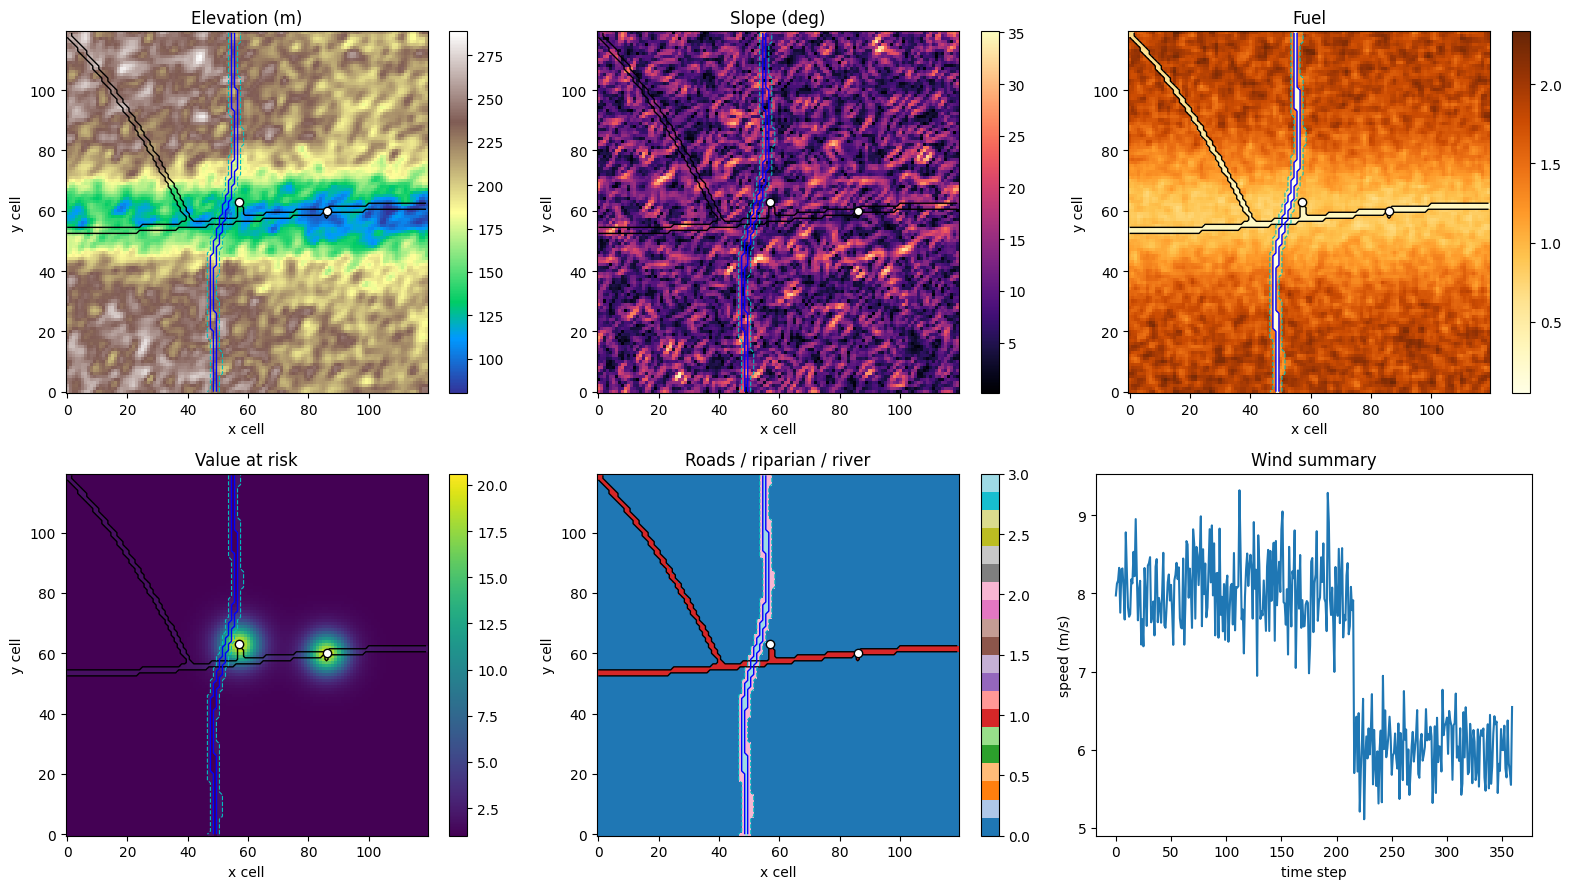

In [5]:
plot_env(realistic_env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask)


## Early-stage ignition near assets


In [6]:
# Ignition near the primary town, slightly upwind
mean_wind = realistic_env.wind[:5].reshape(5, -1, 2).mean(axis=1).mean(axis=0)
ignition_center = choose_ignition_upwind(realistic_env, town_centers, mean_wind, offset_cells=18)

init_state = fire_model.init_state_batch(n_sims=30, center=ignition_center, radius_km=0.05)

drop_opt = RetardantDropBayesOpt(
    fire_model=fire_model,
    init_firestate=init_state,
    n_drones=10,
    evolution_time_s=600.0,
    n_sims=30,
    fire_boundary_probability=0.25,
    search_grid_evolution_time_s=600.0,
)

search_mask, coords = drop_opt.setup_search_grid(K=400, boundary_field="affected")
print("search cells:", coords.shape[0])


No drone_params
search cells: 6319


In [7]:
# Helper: check for repeated drop locations and spacing
def drop_stats(params):
    params = np.asarray(params, float)
    if params.size == 0:
        return {"n_drops": 0, "n_unique": 0, "n_dup": 0, "min_dist": np.nan}
    xy = np.round(params[:, :2]).astype(int)
    uniq = {tuple(row) for row in xy}
    n_dup = int(len(xy) - len(uniq))
    if len(xy) > 1:
        diffs = xy[None, :, :] - xy[:, None, :]
        d = np.sqrt((diffs ** 2).sum(axis=2))
        d += np.eye(len(xy)) * 1e9
        min_dist = float(np.min(d))
    else:
        min_dist = float("nan")
    return {
        "n_drops": int(len(xy)),
        "n_unique": int(len(uniq)),
        "n_dup": int(n_dup),
        "min_dist": min_dist,
    }


## Heuristic test suite

Run each heuristic in isolation plus a few mixes. The summary prints drop duplication
counts and minimum spacing as a basic sanity check.


In [ ]:
# Quick connected-line heuristic sweep (smaller budget than full suite)
preview_evals = 6
preview_plot_each = False
preview_n_sims_plot = 40

connected_line_suite = [
    ("connected_line (default)", {"heuristic_modes": ["connected_line"]}),
    ("connected_line (tighter overlap)", {"heuristic_modes": ["connected_line"], "line_overlap_frac": 0.35}),
    ("connected_line (offset)", {"heuristic_modes": ["connected_line"], "line_offset_cells": 4.0}),
    ("connected_line + downwind", {
        "heuristic_modes": ["connected_line", "downwind_blocking"],
        "heuristic_allocations": {"connected_line": 0.6, "downwind_blocking": 0.4},
        "downwind_offset_cells": 7.0,
    }),
    ("connected_line + tangent", {
        "heuristic_modes": ["connected_line", "tangent_blocking"],
        "heuristic_allocations": {"connected_line": 0.6, "tangent_blocking": 0.4},
        "tangent_offset_cells": 3.0,
    }),
    ("connected_line + asset", {
        "heuristic_modes": ["connected_line", "fire_asset_blocking"],
        "heuristic_allocations": {"connected_line": 0.6, "fire_asset_blocking": 0.4},
        "asset_value_quantile": 0.9,
    }),
]

preview_results = []
for name, hkwargs in connected_line_suite:
    print(f"=== {name} ===")
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=preview_evals,
        heuristic_random_frac=0.0,
        heuristic_kwargs=hkwargs,
        print_every=preview_evals,
    )
    stats = drop_stats(best_params)
    print(
        f"best_y={best_y:.6g} | drops={stats['n_drops']} | "
        f"unique={stats['n_unique']} | dup={stats['n_dup']} | min_dist={stats['min_dist']:.2f}"
    )

    preview_results.append({
        "name": name,
        "best_y": best_y,
        "stats": stats,
        "best_theta": best_theta,
    })

    if preview_plot_each:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=preview_n_sims_plot, title=name)

print("Connected-line summary (lower is better):")
for row in sorted(preview_results, key=lambda r: r["best_y"]):
    s = row["stats"]
    print(f"{row['name']}: best_y={row['best_y']:.6g} | dup={s['n_dup']} | min_dist={s['min_dist']:.2f}")


=== H1+H2+H3 default ===
drone_params: [[27.     66.      4.1581]
 [41.     56.      3.2241]
 [41.     56.      3.6058]
 [46.     73.      1.0359]
 [47.     73.      0.6361]
 [48.     74.      0.5392]
 [49.     71.      0.7737]
 [50.     72.      0.5945]
 [50.     72.      0.8401]
 [54.     93.      0.5779]]
Applying retardant drop: D=[[27.     66.      4.1581]
 [41.     56.      3.2241]
 [41.     56.      3.6058]
 [46.     73.      1.0359]
 [47.     73.      0.6361]
 [48.     74.      0.5392]
 [49.     71.      0.7737]
 [50.     72.      0.5945]
 [50.     72.      0.8401]
 [54.     93.      0.5779]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=12.7439 | best=12.7439
           (x,y,phi) per drone:
           [[27.     66.      4.1581]
 [41.     56.      3.2241]
 [41.     56.      3.6058]
 [46.     73.      1.0359]
 [47.     73.      0.6361]
 [48.     74.      0.5392]
 [49.     71.      0.7737]
 [50.     72.      0.5945]
 [50.     72.      0.8401]
 [54.     93

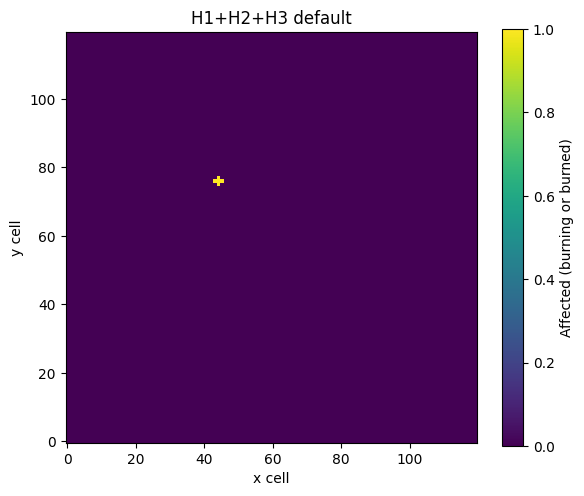

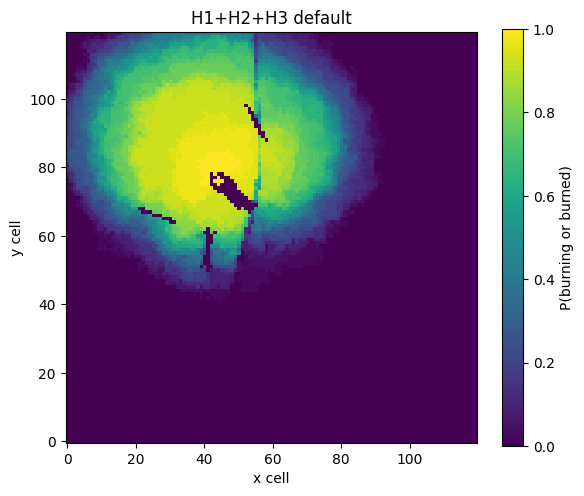

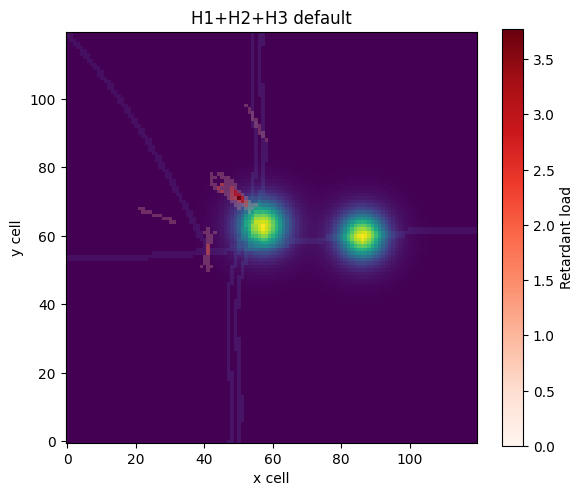

=== H1+H2+H3 (wider spacing) ===
drone_params: [[27.     64.      4.4411]
 [42.     56.      3.0513]
 [46.     72.      0.5304]
 [47.     73.      0.6761]
 [48.     74.      0.8874]
 [49.     71.      0.6367]
 [50.     71.      0.6413]
 [50.     72.      0.3444]
 [53.     94.      0.3015]
 [53.     94.      0.8399]]
Applying retardant drop: D=[[27.     64.      4.4411]
 [42.     56.      3.0513]
 [46.     72.      0.5304]
 [47.     73.      0.6761]
 [48.     74.      0.8874]
 [49.     71.      0.6367]
 [50.     71.      0.6413]
 [50.     72.      0.3444]
 [53.     94.      0.3015]
 [53.     94.      0.8399]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.4412 | best=14.4412
           (x,y,phi) per drone:
           [[27.     64.      4.4411]
 [42.     56.      3.0513]
 [46.     72.      0.5304]
 [47.     73.      0.6761]
 [48.     74.      0.8874]
 [49.     71.      0.6367]
 [50.     71.      0.6413]
 [50.     72.      0.3444]
 [53.     94.      0.3015]
 [53

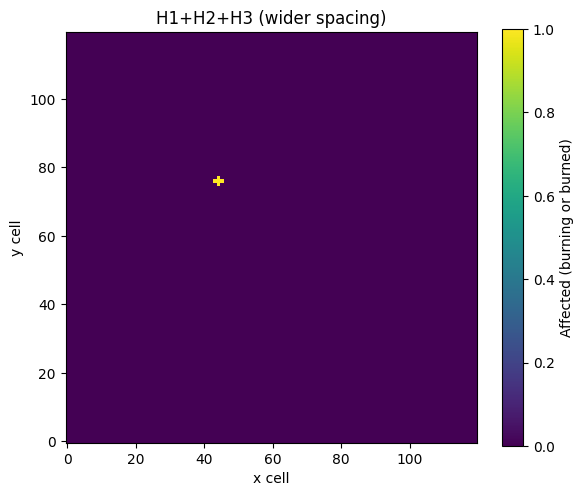

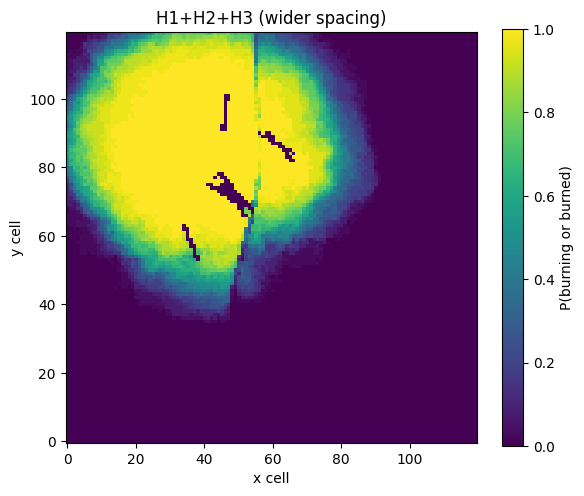

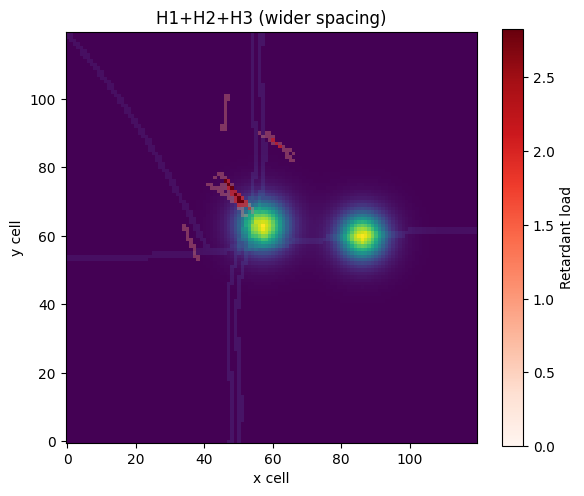

=== H1+H2+H3 (low jitter) ===
drone_params: [[34.     58.      3.5233]
 [46.     72.      0.8529]
 [46.     74.      0.7442]
 [48.     74.      0.7789]
 [48.     96.      0.239 ]
 [49.     71.      0.7167]
 [50.     72.      0.6345]
 [50.     72.      0.6914]
 [62.     85.      1.01  ]
 [62.     85.      1.121 ]]
Applying retardant drop: D=[[34.     58.      3.5233]
 [46.     72.      0.8529]
 [46.     74.      0.7442]
 [48.     74.      0.7789]
 [48.     96.      0.239 ]
 [49.     71.      0.7167]
 [50.     72.      0.6345]
 [50.     72.      0.6914]
 [62.     85.      1.01  ]
 [62.     85.      1.121 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.6201 | best=13.6201
           (x,y,phi) per drone:
           [[34.     58.      3.5233]
 [46.     72.      0.8529]
 [46.     74.      0.7442]
 [48.     74.      0.7789]
 [48.     96.      0.239 ]
 [49.     71.      0.7167]
 [50.     72.      0.6345]
 [50.     72.      0.6914]
 [62.     85.      1.01  ]
 [62.  

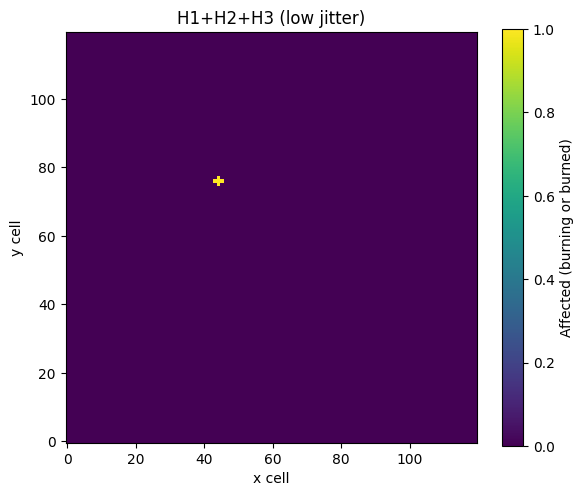

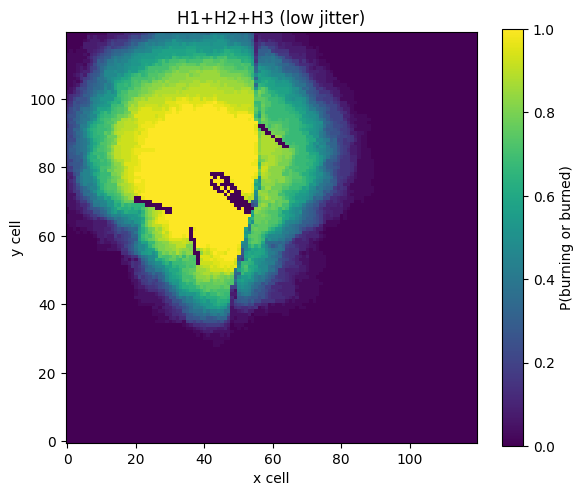

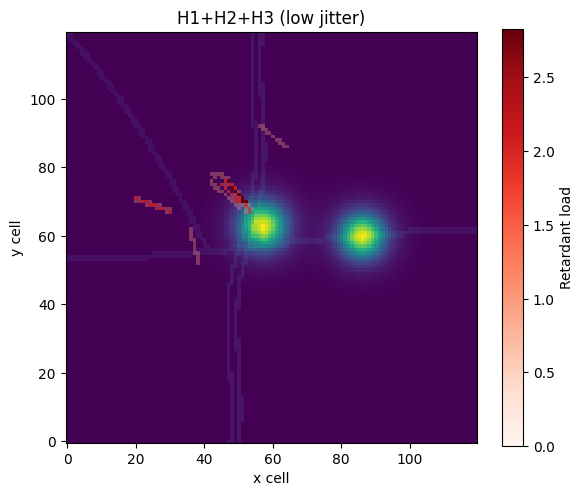

=== H1+H2+H3 (high spacing + low jitter) ===
drone_params: [[34.     59.      3.6369]
 [46.     72.      0.8478]
 [47.     73.      0.6742]
 [48.     74.      0.7597]
 [49.     71.      0.7213]
 [49.     96.      0.2929]
 [49.     96.      0.3149]
 [50.     72.      0.7416]
 [51.     69.      0.6329]
 [63.     84.      1.2297]]
Applying retardant drop: D=[[34.     59.      3.6369]
 [46.     72.      0.8478]
 [47.     73.      0.6742]
 [48.     74.      0.7597]
 [49.     71.      0.7213]
 [49.     96.      0.2929]
 [49.     96.      0.3149]
 [50.     72.      0.7416]
 [51.     69.      0.6329]
 [63.     84.      1.2297]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.894 | best=13.894
           (x,y,phi) per drone:
           [[34.     59.      3.6369]
 [46.     72.      0.8478]
 [47.     73.      0.6742]
 [48.     74.      0.7597]
 [49.     71.      0.7213]
 [49.     96.      0.2929]
 [49.     96.      0.3149]
 [50.     72.      0.7416]
 [51.     69.      0.

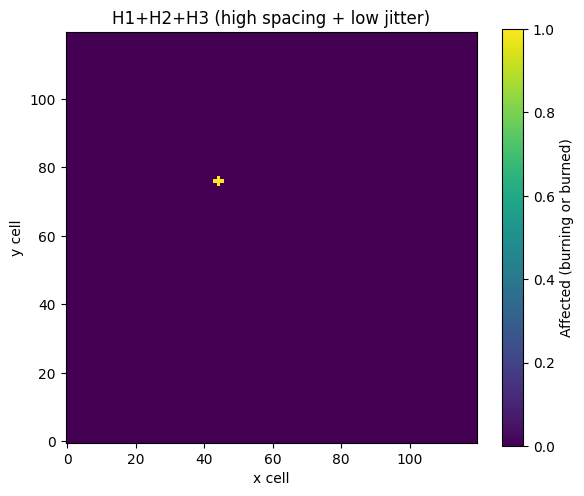

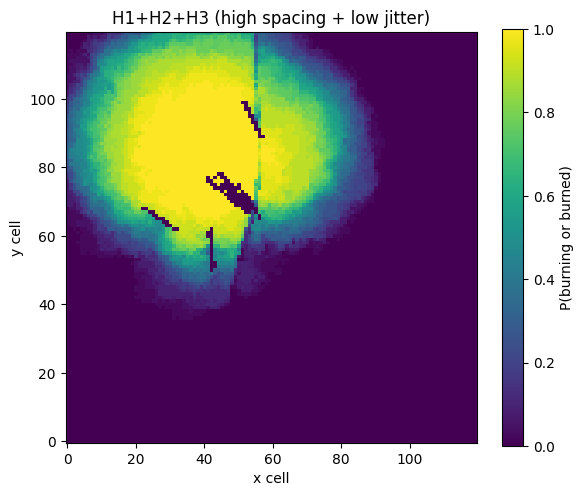

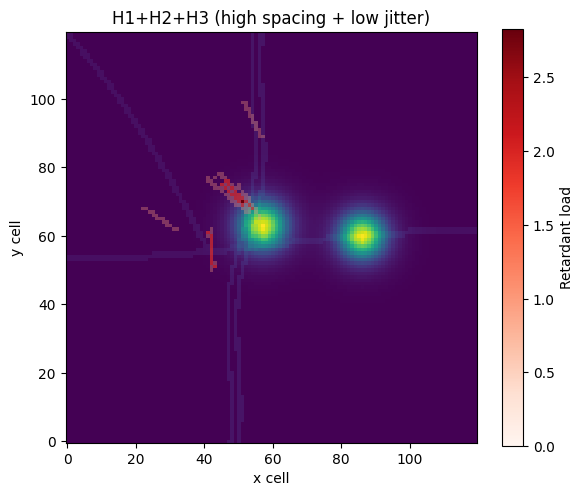

=== H1 asset-focused (tight) ===
drone_params: [[47.     72.      0.681 ]
 [47.     72.      0.9371]
 [48.     71.      0.7367]
 [48.     71.      0.8076]
 [48.     72.      0.6284]
 [48.     72.      0.7719]
 [48.     73.      0.686 ]
 [48.     73.      0.7867]
 [48.     73.      0.8451]
 [49.     72.      0.8675]]
Applying retardant drop: D=[[47.     72.      0.681 ]
 [47.     72.      0.9371]
 [48.     71.      0.7367]
 [48.     71.      0.8076]
 [48.     72.      0.6284]
 [48.     72.      0.7719]
 [48.     73.      0.686 ]
 [48.     73.      0.7867]
 [48.     73.      0.8451]
 [49.     72.      0.8675]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=15.0964 | best=15.0964
           (x,y,phi) per drone:
           [[47.     72.      0.681 ]
 [47.     72.      0.9371]
 [48.     71.      0.7367]
 [48.     71.      0.8076]
 [48.     72.      0.6284]
 [48.     72.      0.7719]
 [48.     73.      0.686 ]
 [48.     73.      0.7867]
 [48.     73.      0.8451]
 [49

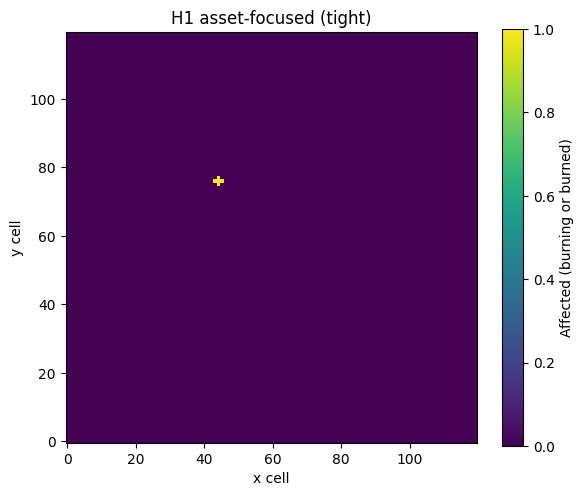

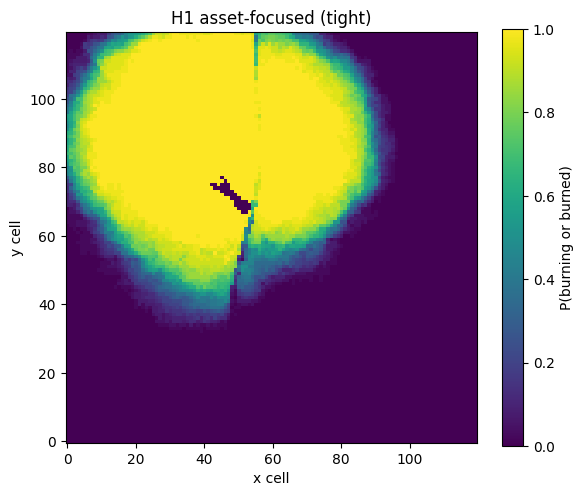

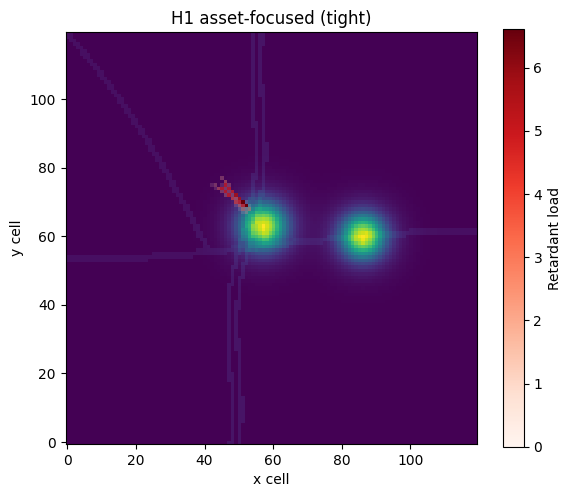

=== H1 asset-focused (broader) ===
drone_params: [[45.     74.      0.3209]
 [45.     74.      0.5133]
 [45.     74.      0.9052]
 [45.     74.      1.1051]
 [45.     74.      1.1316]
 [46.     75.      0.2966]
 [46.     75.      0.4359]
 [46.     75.      0.6265]
 [46.     75.      1.1143]
 [46.     75.      1.1619]]
Applying retardant drop: D=[[45.     74.      0.3209]
 [45.     74.      0.5133]
 [45.     74.      0.9052]
 [45.     74.      1.1051]
 [45.     74.      1.1316]
 [46.     75.      0.2966]
 [46.     75.      0.4359]
 [46.     75.      0.6265]
 [46.     75.      1.1143]
 [46.     75.      1.1619]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=11.211 | best=11.211
           (x,y,phi) per drone:
           [[45.     74.      0.3209]
 [45.     74.      0.5133]
 [45.     74.      0.9052]
 [45.     74.      1.1051]
 [45.     74.      1.1316]
 [46.     75.      0.2966]
 [46.     75.      0.4359]
 [46.     75.      0.6265]
 [46.     75.      1.1143]
 [46

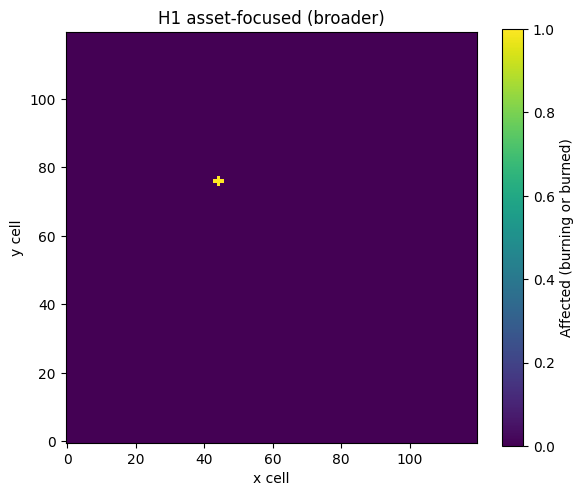

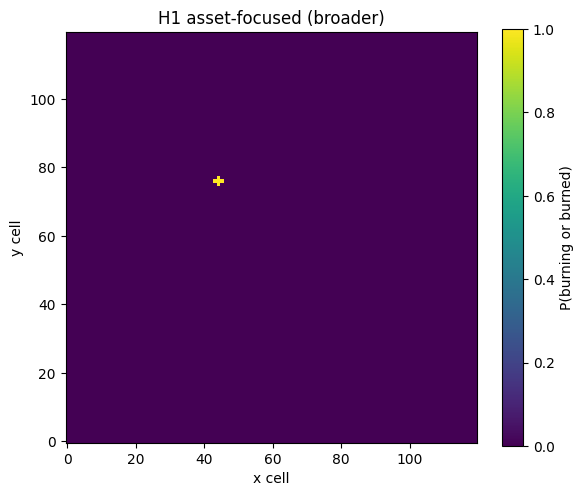

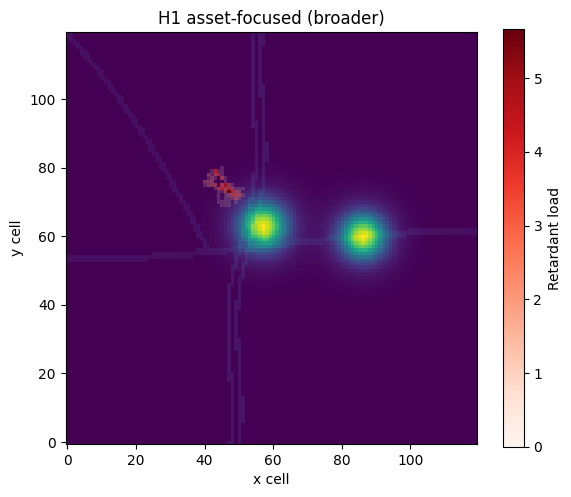

=== H1 asset + boundary fallback ===
drone_params: [[29.     62.      1.9163]
 [33.     59.      2.0765]
 [46.     72.      0.9012]
 [46.     74.      0.4748]
 [47.     73.      0.8966]
 [47.     73.      1.2087]
 [47.     75.      0.9552]
 [53.     64.      0.5258]
 [74.     93.      5.9518]
 [76.     86.      5.9575]]
Applying retardant drop: D=[[29.     62.      1.9163]
 [33.     59.      2.0765]
 [46.     72.      0.9012]
 [46.     74.      0.4748]
 [47.     73.      0.8966]
 [47.     73.      1.2087]
 [47.     75.      0.9552]
 [53.     64.      0.5258]
 [74.     93.      5.9518]
 [76.     86.      5.9575]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.3881 | best=13.3881
           (x,y,phi) per drone:
           [[29.     62.      1.9163]
 [33.     59.      2.0765]
 [46.     72.      0.9012]
 [46.     74.      0.4748]
 [47.     73.      0.8966]
 [47.     73.      1.2087]
 [47.     75.      0.9552]
 [53.     64.      0.5258]
 [74.     93.      5.9518]


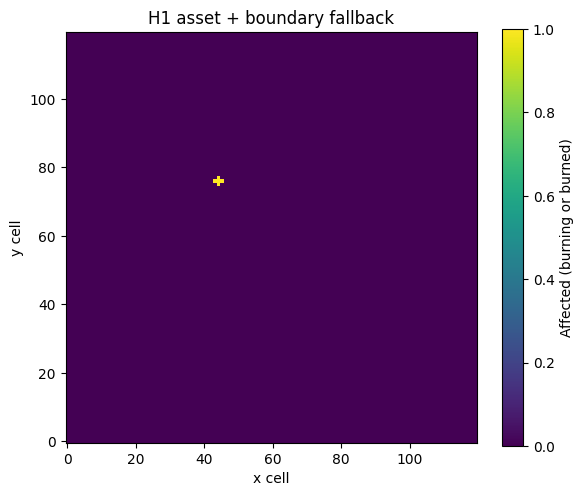

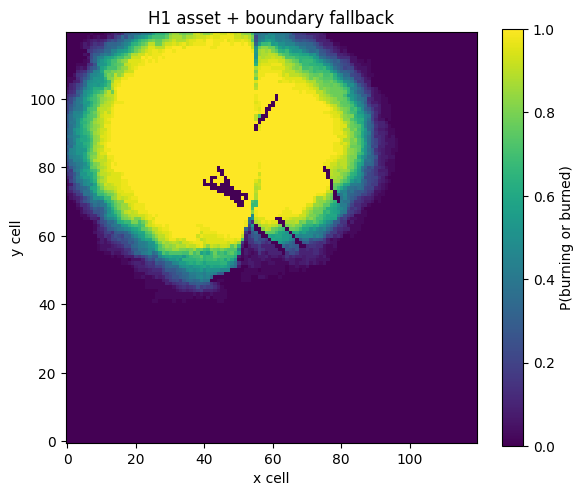

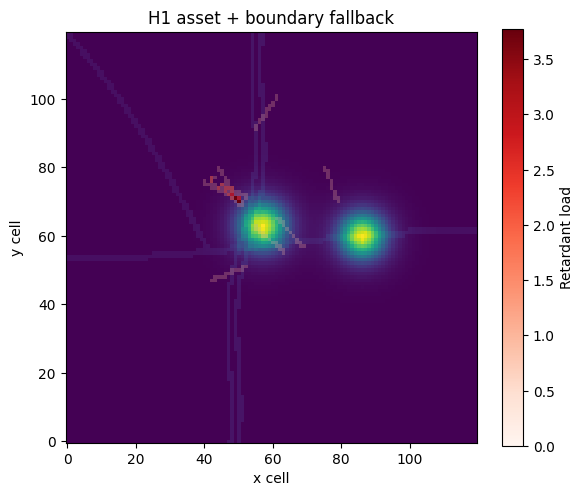

=== H1 asset (high spacing) ===
drone_params: [[46.     72.      0.7504]
 [46.     73.      0.5596]
 [46.     73.      1.0122]
 [47.     72.      0.6841]
 [47.     72.      0.7793]
 [47.     74.      0.7932]
 [47.     74.      0.8102]
 [48.     73.      0.6359]
 [48.     73.      0.884 ]
 [48.     74.      0.9195]]
Applying retardant drop: D=[[46.     72.      0.7504]
 [46.     73.      0.5596]
 [46.     73.      1.0122]
 [47.     72.      0.6841]
 [47.     72.      0.7793]
 [47.     74.      0.7932]
 [47.     74.      0.8102]
 [48.     73.      0.6359]
 [48.     73.      0.884 ]
 [48.     74.      0.9195]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.8313 | best=14.8313
           (x,y,phi) per drone:
           [[46.     72.      0.7504]
 [46.     73.      0.5596]
 [46.     73.      1.0122]
 [47.     72.      0.6841]
 [47.     72.      0.7793]
 [47.     74.      0.7932]
 [47.     74.      0.8102]
 [48.     73.      0.6359]
 [48.     73.      0.884 ]
 [48.

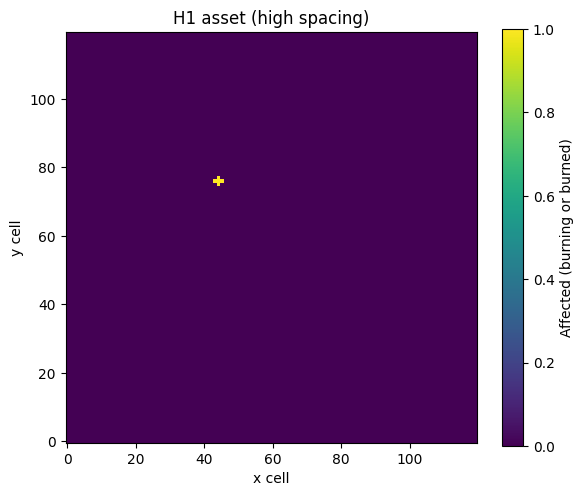

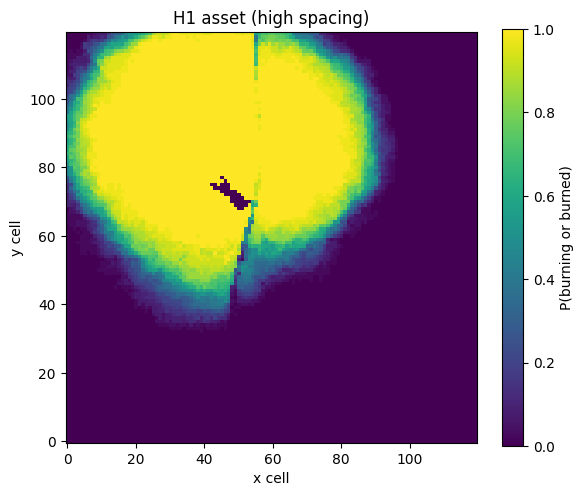

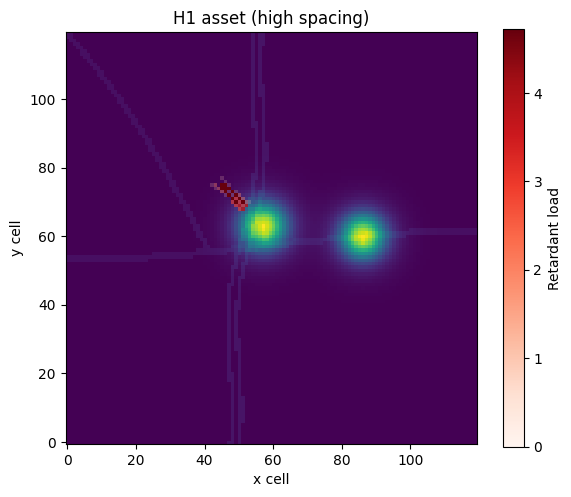

=== H1 asset (close-in, spaced) ===
drone_params: [[45.     73.      0.7307]
 [45.     73.      0.7953]
 [45.     73.      0.9449]
 [46.     74.      0.614 ]
 [46.     74.      0.8418]
 [46.     74.      0.8544]
 [47.     75.      0.6654]
 [47.     75.      0.819 ]
 [47.     75.      0.8233]
 [47.     75.      0.833 ]]
Applying retardant drop: D=[[45.     73.      0.7307]
 [45.     73.      0.7953]
 [45.     73.      0.9449]
 [46.     74.      0.614 ]
 [46.     74.      0.8418]
 [46.     74.      0.8544]
 [47.     75.      0.6654]
 [47.     75.      0.819 ]
 [47.     75.      0.8233]
 [47.     75.      0.833 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=0.0123608 | best=0.0123608
           (x,y,phi) per drone:
           [[45.     73.      0.7307]
 [45.     73.      0.7953]
 [45.     73.      0.9449]
 [46.     74.      0.614 ]
 [46.     74.      0.8418]
 [46.     74.      0.8544]
 [47.     75.      0.6654]
 [47.     75.      0.819 ]
 [47.     75.      0.823

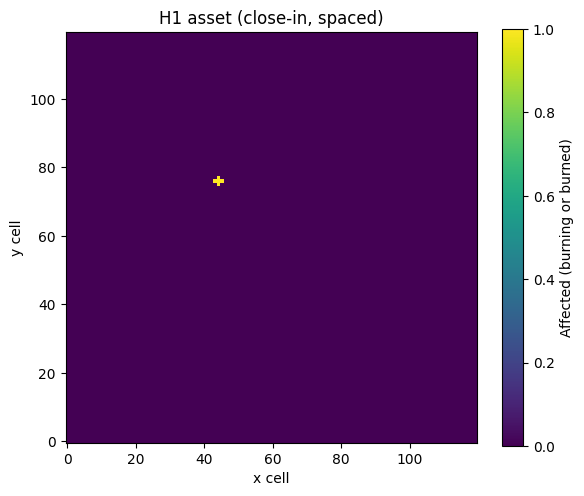

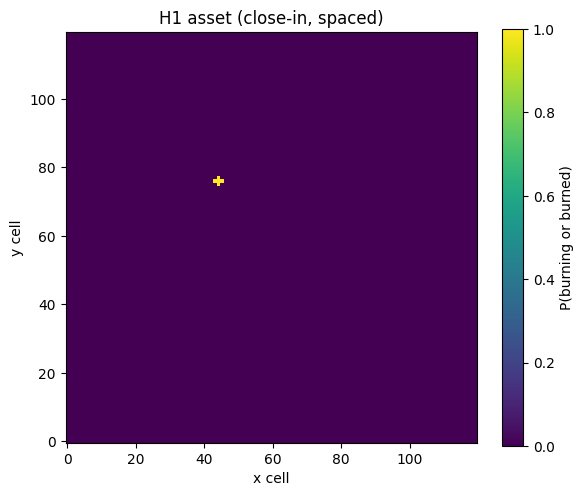

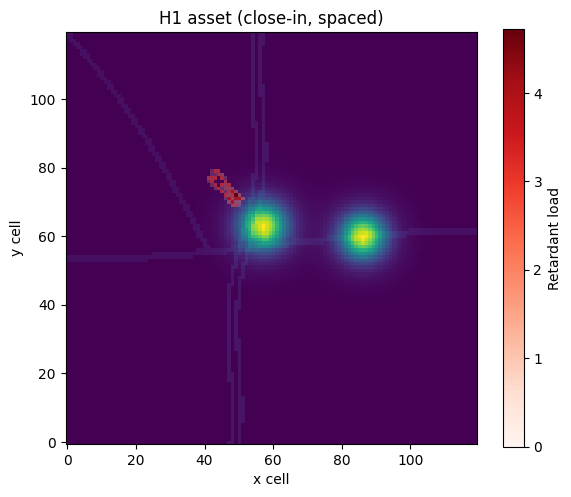

=== H2 downwind (perp, layered) ===
drone_params: [[50.     69.      0.5012]
 [50.     69.      0.6977]
 [50.     70.      0.6106]
 [51.     70.      0.5235]
 [51.     70.      0.606 ]
 [51.     70.      0.7158]
 [51.     70.      0.7707]
 [52.     71.      0.586 ]
 [52.     71.      0.6981]
 [52.     71.      0.8788]]
Applying retardant drop: D=[[50.     69.      0.5012]
 [50.     69.      0.6977]
 [50.     70.      0.6106]
 [51.     70.      0.5235]
 [51.     70.      0.606 ]
 [51.     70.      0.7158]
 [51.     70.      0.7707]
 [52.     71.      0.586 ]
 [52.     71.      0.6981]
 [52.     71.      0.8788]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.9224 | best=14.9224
           (x,y,phi) per drone:
           [[50.     69.      0.5012]
 [50.     69.      0.6977]
 [50.     70.      0.6106]
 [51.     70.      0.5235]
 [51.     70.      0.606 ]
 [51.     70.      0.7158]
 [51.     70.      0.7707]
 [52.     71.      0.586 ]
 [52.     71.      0.6981]
 

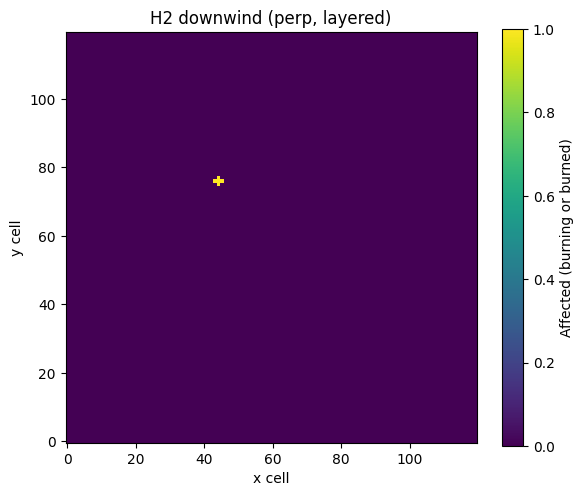

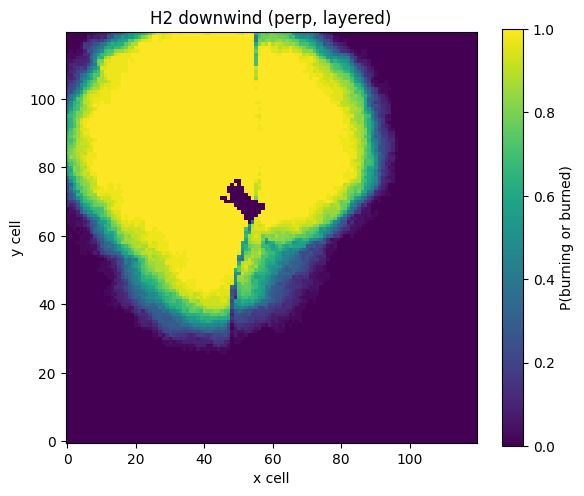

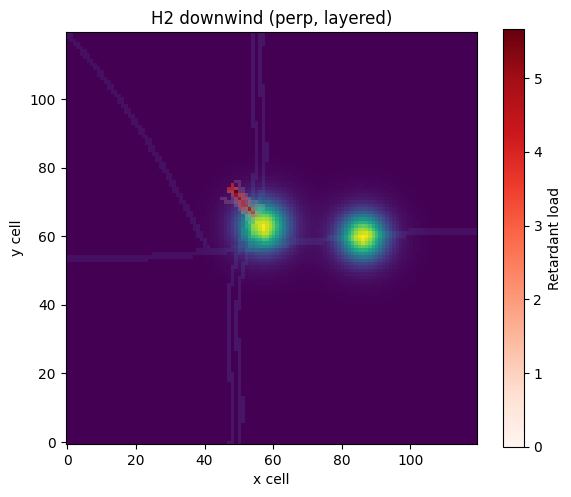

=== H2 downwind (perp, close-in) ===
drone_params: [[48.     71.      0.3942]
 [48.     71.      0.6234]
 [48.     71.      0.6609]
 [48.     71.      0.7011]
 [48.     71.      0.9346]
 [48.     72.      0.8468]
 [49.     72.      0.7285]
 [49.     73.      0.357 ]
 [49.     73.      0.7259]
 [50.     73.      0.724 ]]
Applying retardant drop: D=[[48.     71.      0.3942]
 [48.     71.      0.6234]
 [48.     71.      0.6609]
 [48.     71.      0.7011]
 [48.     71.      0.9346]
 [48.     72.      0.8468]
 [49.     72.      0.7285]
 [49.     73.      0.357 ]
 [49.     73.      0.7259]
 [50.     73.      0.724 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.6111 | best=13.6111
           (x,y,phi) per drone:
           [[48.     71.      0.3942]
 [48.     71.      0.6234]
 [48.     71.      0.6609]
 [48.     71.      0.7011]
 [48.     71.      0.9346]
 [48.     72.      0.8468]
 [49.     72.      0.7285]
 [49.     73.      0.357 ]
 [49.     73.      0.7259]


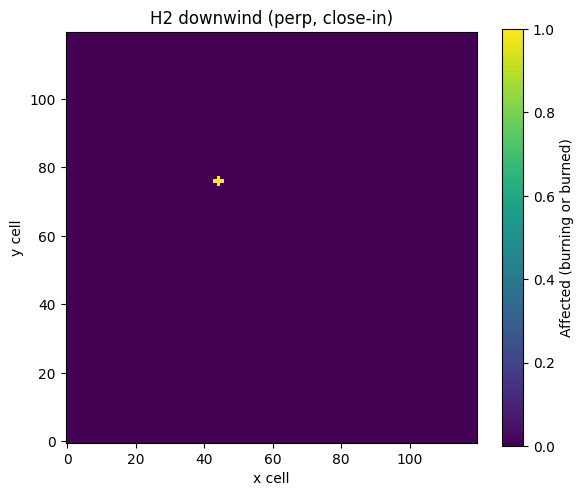

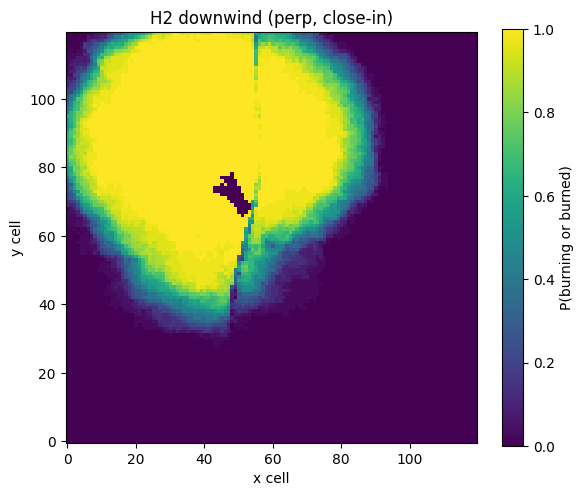

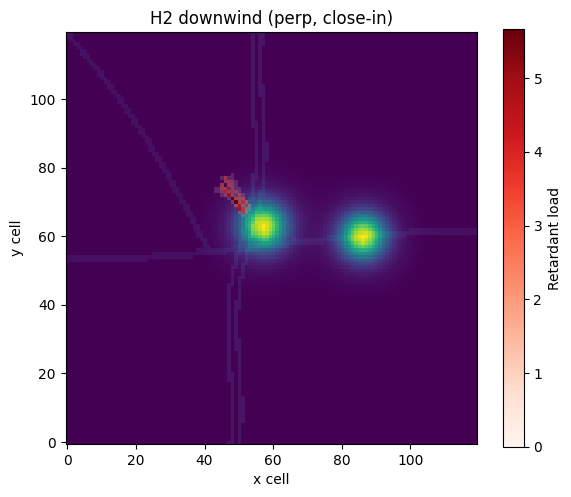

=== H2 downwind (perp, high spacing) ===
drone_params: [[50.     69.      0.4578]
 [50.     69.      0.8135]
 [51.     70.      0.3463]
 [51.     70.      0.7645]
 [51.     70.      1.0783]
 [52.     71.      0.506 ]
 [52.     71.      0.6131]
 [52.     71.      0.6511]
 [55.     67.      0.5483]
 [56.     68.      0.4134]]
Applying retardant drop: D=[[50.     69.      0.4578]
 [50.     69.      0.8135]
 [51.     70.      0.3463]
 [51.     70.      0.7645]
 [51.     70.      1.0783]
 [52.     71.      0.506 ]
 [52.     71.      0.6131]
 [52.     71.      0.6511]
 [55.     67.      0.5483]
 [56.     68.      0.4134]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.3814 | best=14.3814
           (x,y,phi) per drone:
           [[50.     69.      0.4578]
 [50.     69.      0.8135]
 [51.     70.      0.3463]
 [51.     70.      0.7645]
 [51.     70.      1.0783]
 [52.     71.      0.506 ]
 [52.     71.      0.6131]
 [52.     71.      0.6511]
 [55.     67.      0.54

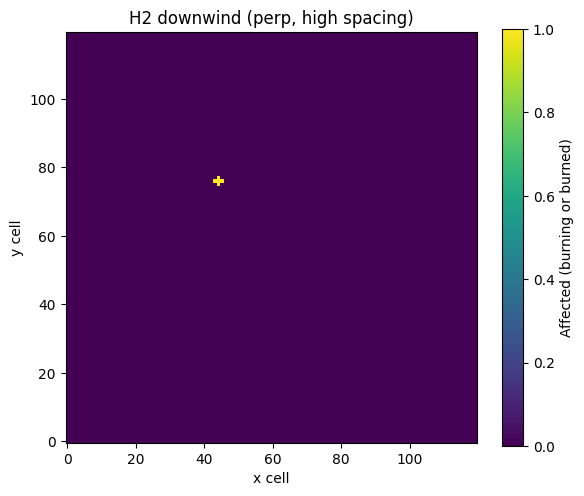

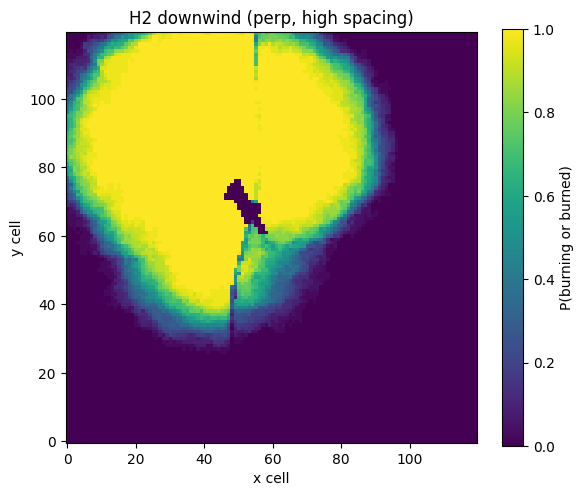

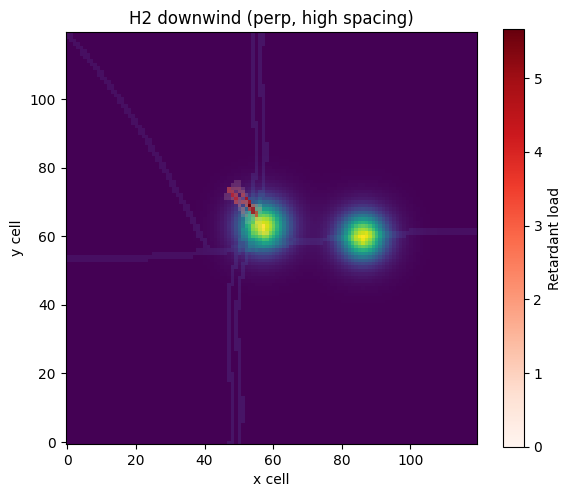

=== H2 downwind (perp, multi-layer) ===
drone_params: [[49.     70.      0.6803]
 [49.     70.      0.7435]
 [50.     70.      0.7324]
 [50.     70.      0.7907]
 [50.     71.      0.4716]
 [50.     71.      0.5199]
 [51.     71.      0.8397]
 [51.     71.      0.937 ]
 [51.     72.      0.4394]
 [51.     72.      0.763 ]]
Applying retardant drop: D=[[49.     70.      0.6803]
 [49.     70.      0.7435]
 [50.     70.      0.7324]
 [50.     70.      0.7907]
 [50.     71.      0.4716]
 [50.     71.      0.5199]
 [51.     71.      0.8397]
 [51.     71.      0.937 ]
 [51.     72.      0.4394]
 [51.     72.      0.763 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.8387 | best=14.8387
           (x,y,phi) per drone:
           [[49.     70.      0.6803]
 [49.     70.      0.7435]
 [50.     70.      0.7324]
 [50.     70.      0.7907]
 [50.     71.      0.4716]
 [50.     71.      0.5199]
 [51.     71.      0.8397]
 [51.     71.      0.937 ]
 [51.     72.      0.439

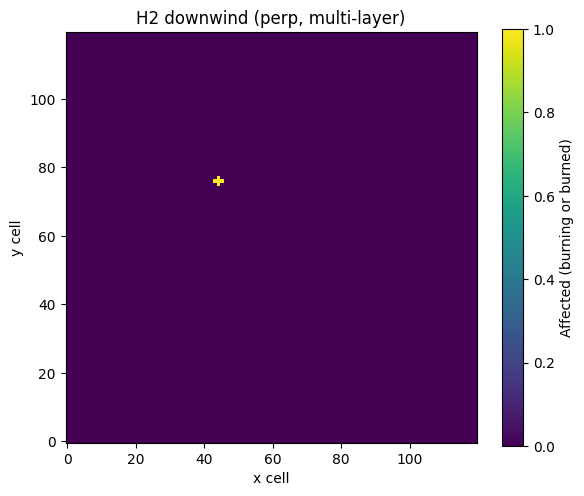

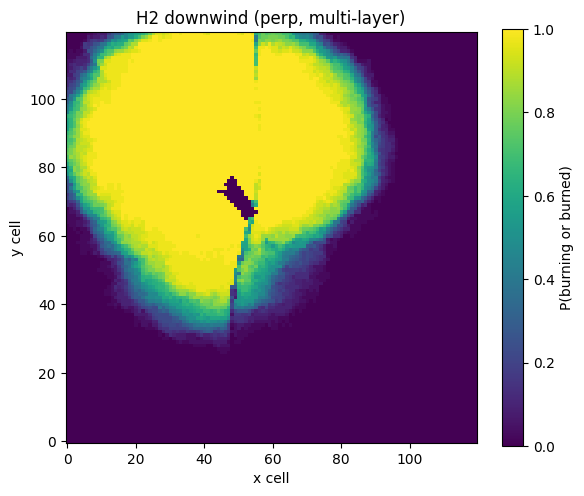

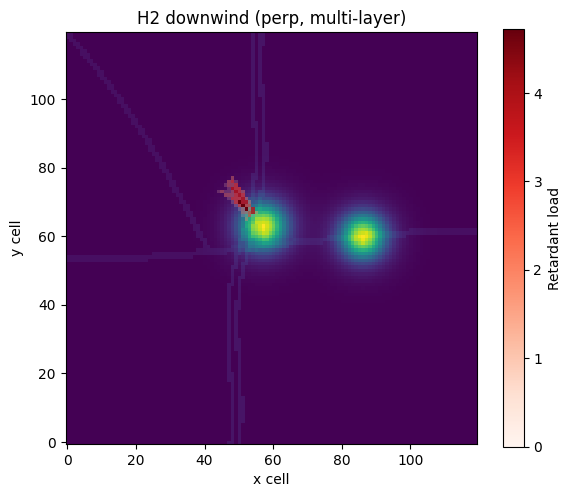

=== H2 downwind (parallel, legacy) ===
drone_params: [[50.     69.      1.7708]
 [50.     69.      2.4933]
 [50.     70.      2.3991]
 [51.     70.      1.9431]
 [51.     70.      2.1388]
 [51.     70.      2.1463]
 [51.     70.      2.2328]
 [52.     71.      2.1456]
 [52.     71.      2.297 ]
 [52.     71.      2.3436]]
Applying retardant drop: D=[[50.     69.      1.7708]
 [50.     69.      2.4933]
 [50.     70.      2.3991]
 [51.     70.      1.9431]
 [51.     70.      2.1388]
 [51.     70.      2.1463]
 [51.     70.      2.2328]
 [52.     71.      2.1456]
 [52.     71.      2.297 ]
 [52.     71.      2.3436]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.6904 | best=14.6904
           (x,y,phi) per drone:
           [[50.     69.      1.7708]
 [50.     69.      2.4933]
 [50.     70.      2.3991]
 [51.     70.      1.9431]
 [51.     70.      2.1388]
 [51.     70.      2.1463]
 [51.     70.      2.2328]
 [52.     71.      2.1456]
 [52.     71.      2.297 

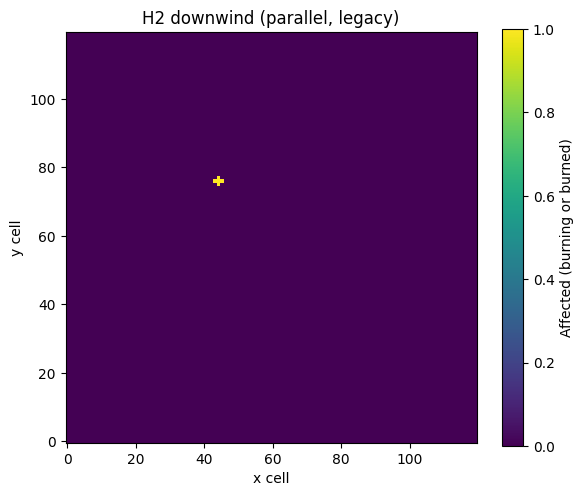

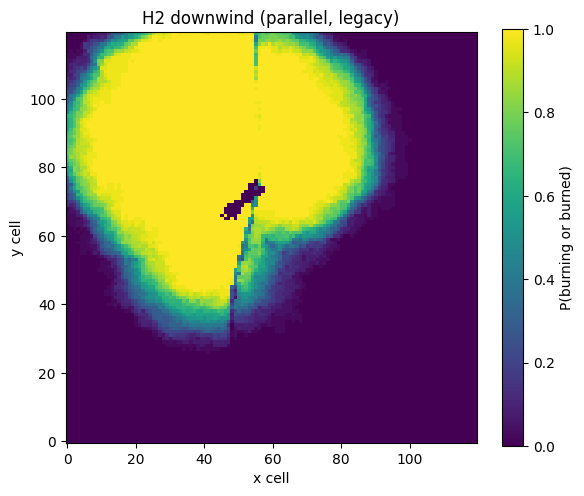

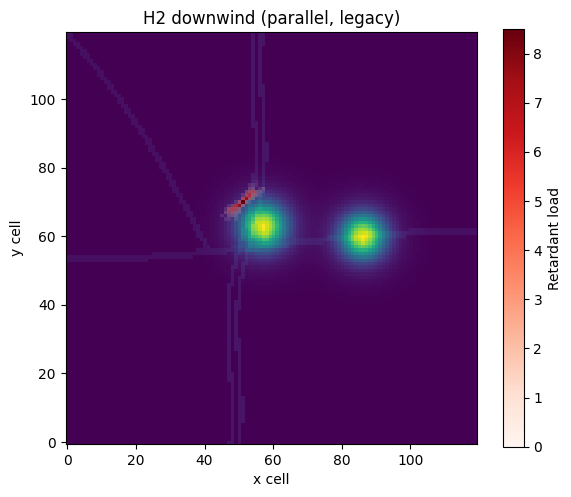

=== H3 tangent (normal) ===
drone_params: [[ 16.      70.       4.0624]
 [ 20.      62.       4.1416]
 [ 33.      50.       3.7397]
 [ 38.      48.       3.2954]
 [ 45.      48.       3.012 ]
 [ 46.     104.       0.0538]
 [ 54.     103.       0.4328]
 [ 68.      90.       1.0882]
 [ 68.      91.       1.2642]
 [ 71.      84.       1.1347]]
Applying retardant drop: D=[[ 16.      70.       4.0624]
 [ 20.      62.       4.1416]
 [ 33.      50.       3.7397]
 [ 38.      48.       3.2954]
 [ 45.      48.       3.012 ]
 [ 46.     104.       0.0538]
 [ 54.     103.       0.4328]
 [ 68.      90.       1.0882]
 [ 68.      91.       1.2642]
 [ 71.      84.       1.1347]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=15.4359 | best=15.4359
           (x,y,phi) per drone:
           [[ 16.      70.       4.0624]
 [ 20.      62.       4.1416]
 [ 33.      50.       3.7397]
 [ 38.      48.       3.2954]
 [ 45.      48.       3.012 ]
 [ 46.     104.       0.0538]
 [ 54.     1

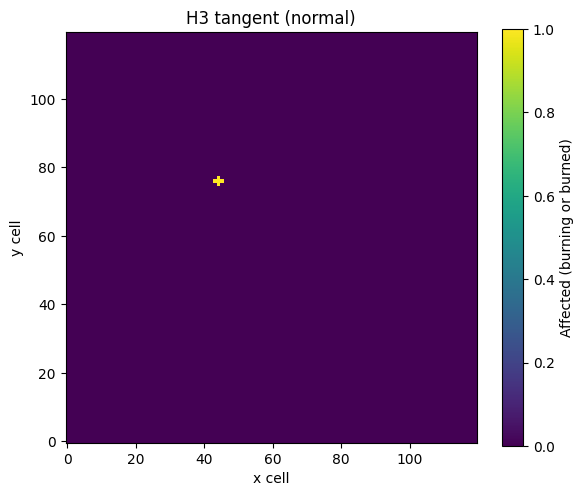

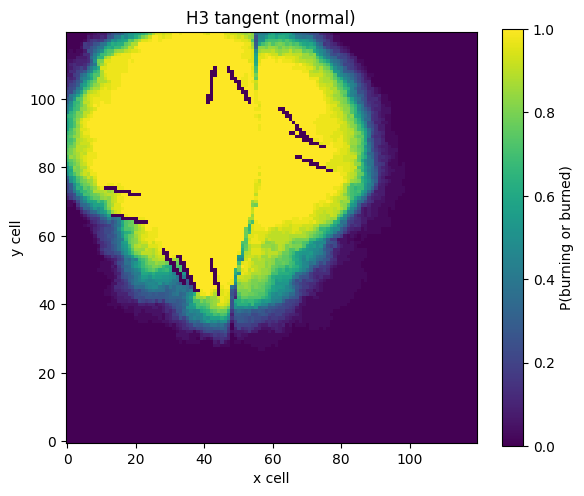

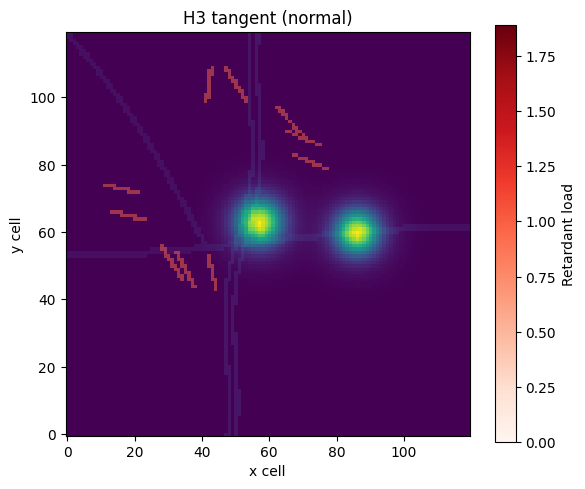

=== H3 tangent (normal, farther) ===
drone_params: [[ 13.      61.       4.6048]
 [ 18.      54.       3.8831]
 [ 32.      44.       3.3725]
 [ 39.      42.       3.699 ]
 [ 44.     111.       0.0887]
 [ 54.     109.       0.4845]
 [ 61.     106.       0.6218]
 [ 74.      93.       1.031 ]
 [ 74.      93.       1.1267]
 [ 77.      85.       1.5909]]
Applying retardant drop: D=[[ 13.      61.       4.6048]
 [ 18.      54.       3.8831]
 [ 32.      44.       3.3725]
 [ 39.      42.       3.699 ]
 [ 44.     111.       0.0887]
 [ 54.     109.       0.4845]
 [ 61.     106.       0.6218]
 [ 74.      93.       1.031 ]
 [ 74.      93.       1.1267]
 [ 77.      85.       1.5909]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=15.6254 | best=15.6254
           (x,y,phi) per drone:
           [[ 13.      61.       4.6048]
 [ 18.      54.       3.8831]
 [ 32.      44.       3.3725]
 [ 39.      42.       3.699 ]
 [ 44.     111.       0.0887]
 [ 54.     109.       0.4845]
 [ 

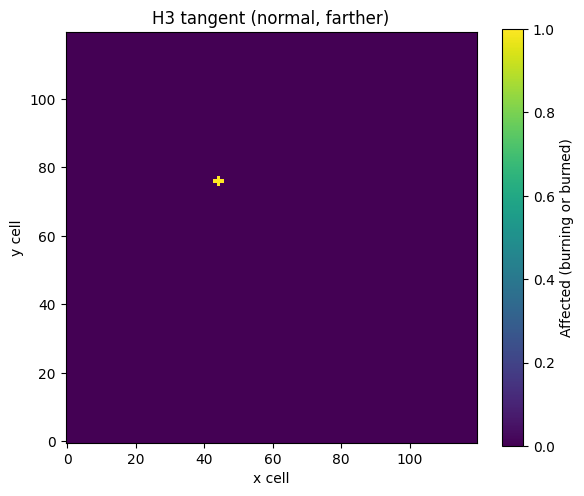

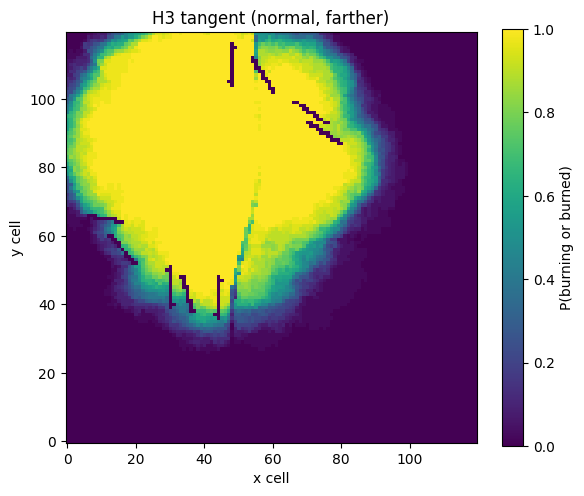

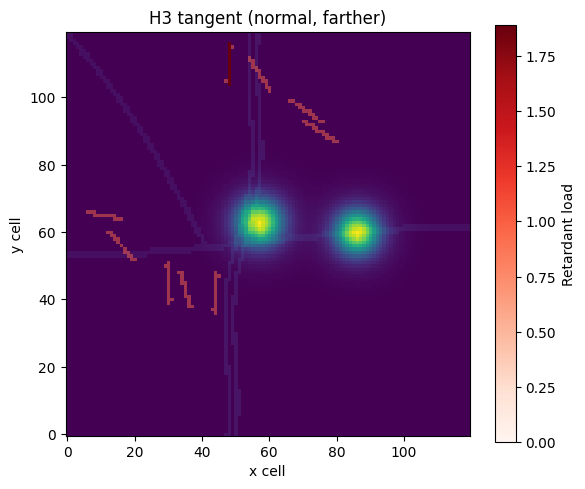

=== H3 tangent (normal, high spacing) ===
drone_params: [[ 18.      62.       4.4294]
 [ 22.      57.       3.8807]
 [ 31.      50.       3.7411]
 [ 35.      48.       3.1438]
 [ 49.     105.       0.0488]
 [ 56.     103.       0.594 ]
 [ 65.      96.       0.7639]
 [ 69.      91.       1.0679]
 [ 69.      92.       1.1361]
 [ 72.      86.       1.5859]]
Applying retardant drop: D=[[ 18.      62.       4.4294]
 [ 22.      57.       3.8807]
 [ 31.      50.       3.7411]
 [ 35.      48.       3.1438]
 [ 49.     105.       0.0488]
 [ 56.     103.       0.594 ]
 [ 65.      96.       0.7639]
 [ 69.      91.       1.0679]
 [ 69.      92.       1.1361]
 [ 72.      86.       1.5859]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=15.4536 | best=15.4536
           (x,y,phi) per drone:
           [[ 18.      62.       4.4294]
 [ 22.      57.       3.8807]
 [ 31.      50.       3.7411]
 [ 35.      48.       3.1438]
 [ 49.     105.       0.0488]
 [ 56.     103.       0.594 

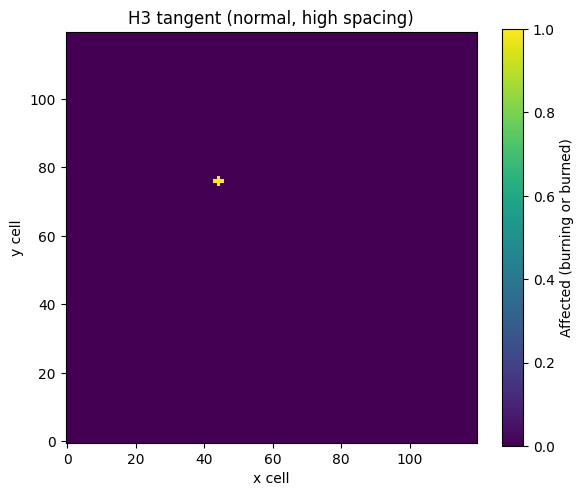

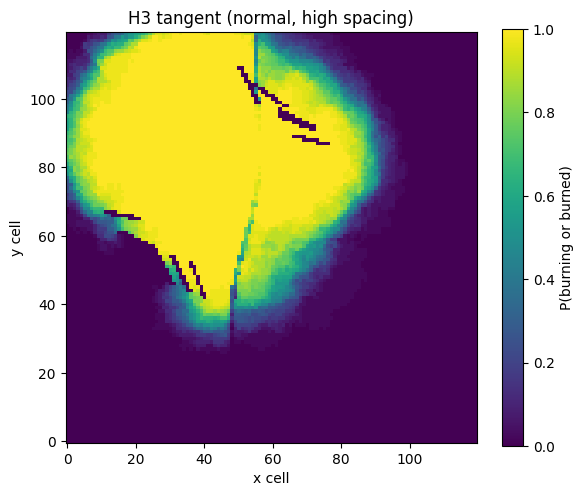

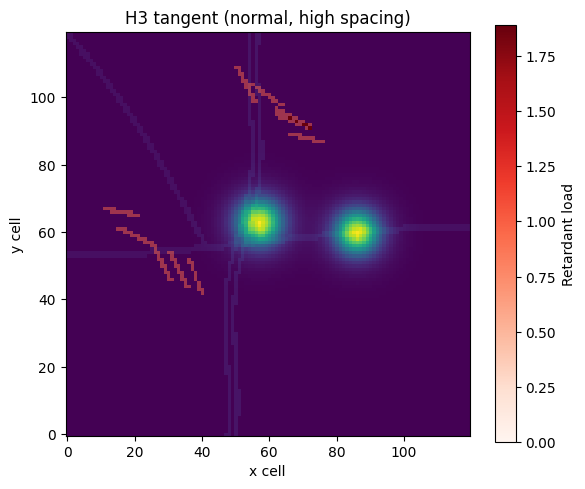

=== H3 tangent (parallel, legacy) ===
drone_params: [[ 17.      66.       2.3833]
 [ 21.      59.       2.5328]
 [ 35.      49.       2.2894]
 [ 42.      48.       2.5367]
 [ 42.     105.       5.3583]
 [ 43.     105.       5.7733]
 [ 51.     103.       5.3355]
 [ 67.      93.       5.5656]
 [ 70.      87.       5.5574]
 [ 72.      80.       5.5423]]
Applying retardant drop: D=[[ 17.      66.       2.3833]
 [ 21.      59.       2.5328]
 [ 35.      49.       2.2894]
 [ 42.      48.       2.5367]
 [ 42.     105.       5.3583]
 [ 43.     105.       5.7733]
 [ 51.     103.       5.3355]
 [ 67.      93.       5.5656]
 [ 70.      87.       5.5574]
 [ 72.      80.       5.5423]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=15.6847 | best=15.6847
           (x,y,phi) per drone:
           [[ 17.      66.       2.3833]
 [ 21.      59.       2.5328]
 [ 35.      49.       2.2894]
 [ 42.      48.       2.5367]
 [ 42.     105.       5.3583]
 [ 43.     105.       5.7733]
 [

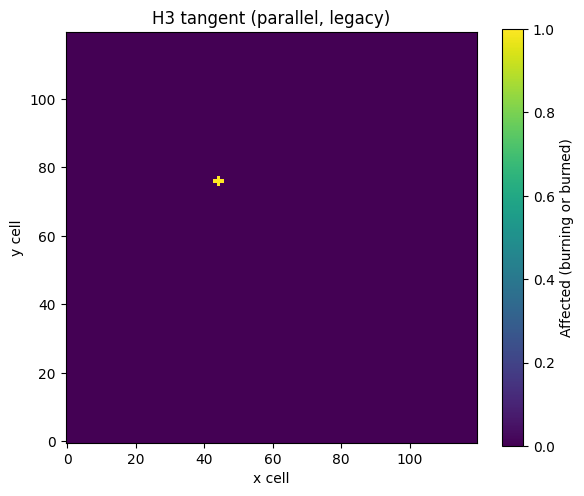

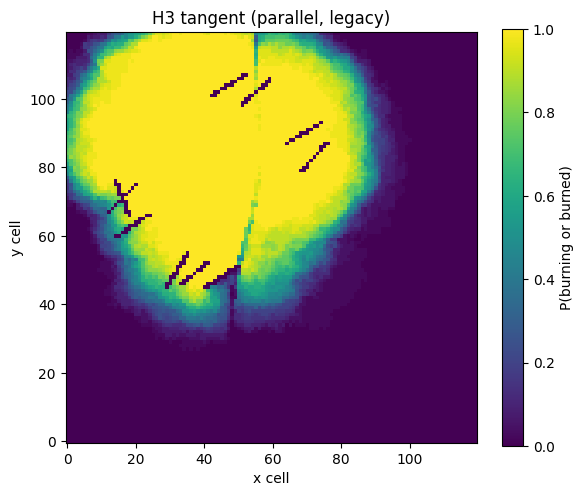

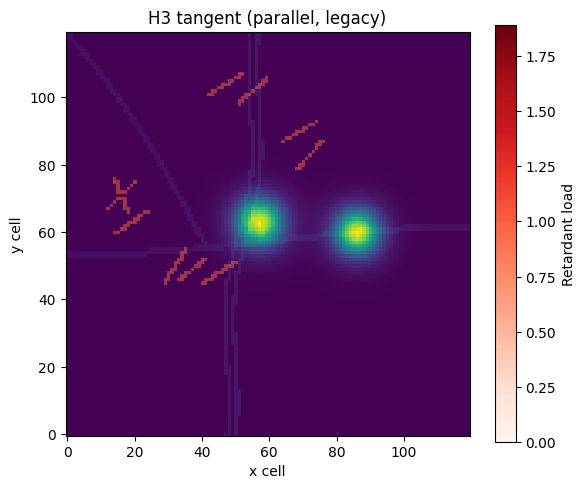

=== H1+H2 ===
drone_params: [[46.     72.      1.0103]
 [46.     73.      0.6169]
 [47.     73.      0.9108]
 [47.     74.      0.8517]
 [47.     75.      0.7895]
 [50.     69.      0.3109]
 [50.     70.      0.6334]
 [52.     71.      0.3546]
 [52.     71.      0.4961]
 [52.     71.      0.5977]]
Applying retardant drop: D=[[46.     72.      1.0103]
 [46.     73.      0.6169]
 [47.     73.      0.9108]
 [47.     74.      0.8517]
 [47.     75.      0.7895]
 [50.     69.      0.3109]
 [50.     70.      0.6334]
 [52.     71.      0.3546]
 [52.     71.      0.4961]
 [52.     71.      0.5977]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.8158 | best=13.8158
           (x,y,phi) per drone:
           [[46.     72.      1.0103]
 [46.     73.      0.6169]
 [47.     73.      0.9108]
 [47.     74.      0.8517]
 [47.     75.      0.7895]
 [50.     69.      0.3109]
 [50.     70.      0.6334]
 [52.     71.      0.3546]
 [52.     71.      0.4961]
 [52.     71.      0.59

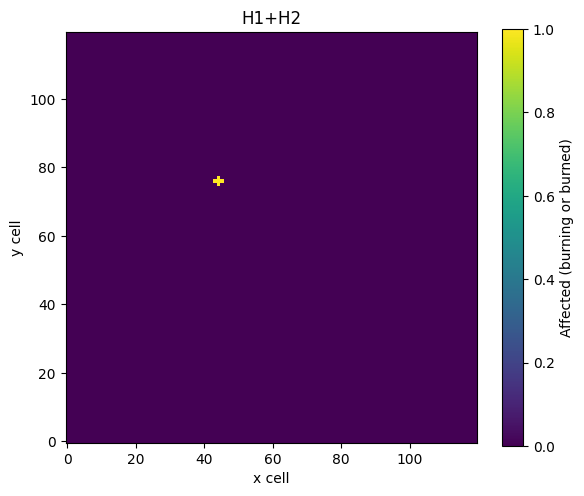

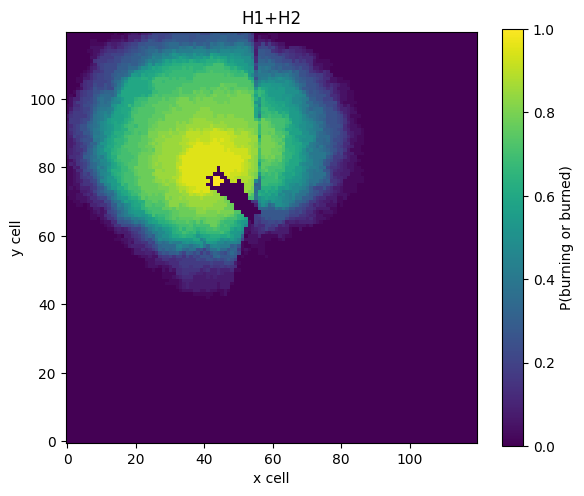

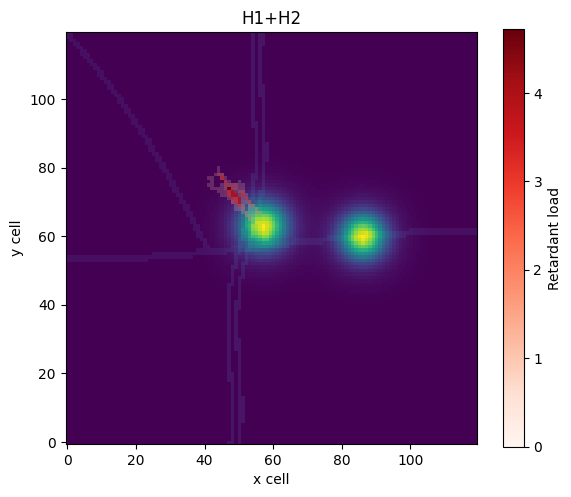

=== H1+H3 ===
drone_params: [[24.     69.      4.1638]
 [34.     57.      3.2394]
 [46.     72.      0.9261]
 [47.     73.      0.421 ]
 [47.     73.      0.7111]
 [47.     73.      1.1918]
 [47.     74.      0.6335]
 [55.     94.      0.4964]
 [64.     83.      1.3414]
 [64.     83.      1.3656]]
Applying retardant drop: D=[[24.     69.      4.1638]
 [34.     57.      3.2394]
 [46.     72.      0.9261]
 [47.     73.      0.421 ]
 [47.     73.      0.7111]
 [47.     73.      1.1918]
 [47.     74.      0.6335]
 [55.     94.      0.4964]
 [64.     83.      1.3414]
 [64.     83.      1.3656]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.668 | best=13.668
           (x,y,phi) per drone:
           [[24.     69.      4.1638]
 [34.     57.      3.2394]
 [46.     72.      0.9261]
 [47.     73.      0.421 ]
 [47.     73.      0.7111]
 [47.     73.      1.1918]
 [47.     74.      0.6335]
 [55.     94.      0.4964]
 [64.     83.      1.3414]
 [64.     83.      1.3656

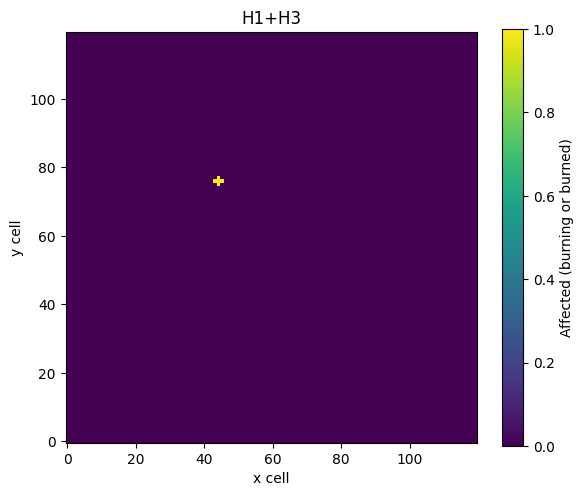

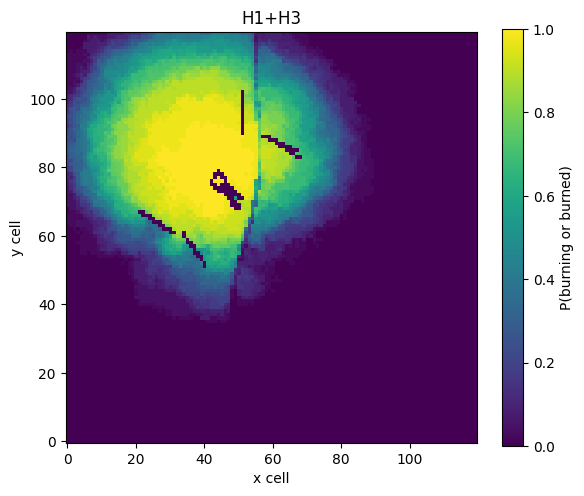

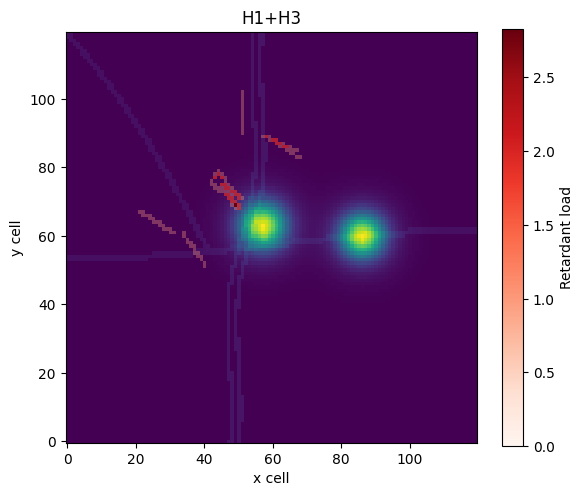

=== H2+H3 ===
drone_params: [[28.     63.      3.8539]
 [28.     64.      4.1074]
 [39.     56.      3.1183]
 [49.     96.      6.2367]
 [50.     69.      1.0778]
 [50.     70.      0.6094]
 [52.     71.      0.5435]
 [52.     71.      0.803 ]
 [52.     71.      0.8773]
 [61.     87.      1.0355]]
Applying retardant drop: D=[[28.     63.      3.8539]
 [28.     64.      4.1074]
 [39.     56.      3.1183]
 [49.     96.      6.2367]
 [50.     69.      1.0778]
 [50.     70.      0.6094]
 [52.     71.      0.5435]
 [52.     71.      0.803 ]
 [52.     71.      0.8773]
 [61.     87.      1.0355]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.6116 | best=14.6116
           (x,y,phi) per drone:
           [[28.     63.      3.8539]
 [28.     64.      4.1074]
 [39.     56.      3.1183]
 [49.     96.      6.2367]
 [50.     69.      1.0778]
 [50.     70.      0.6094]
 [52.     71.      0.5435]
 [52.     71.      0.803 ]
 [52.     71.      0.8773]
 [61.     87.      1.03

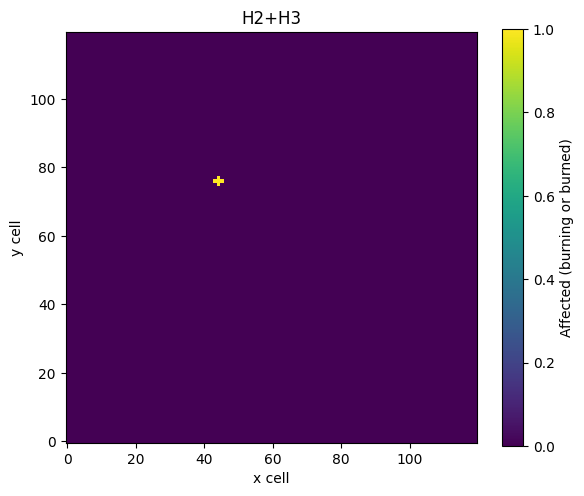

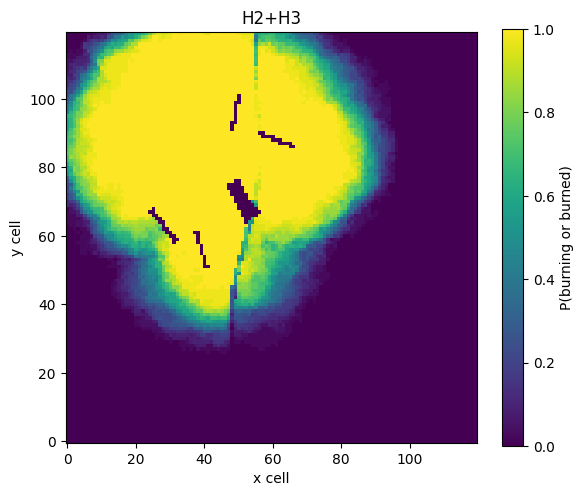

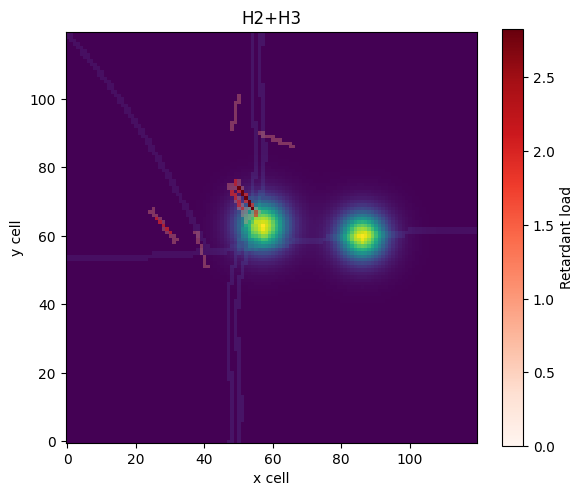

=== H1+H2+H3 (asset heavy) ===
drone_params: [[24.     71.      4.6269]
 [24.     71.      4.6634]
 [36.     57.      3.3222]
 [47.     72.      0.7721]
 [48.     73.      0.6274]
 [49.     73.      0.6557]
 [50.     69.      0.9037]
 [51.     70.      0.357 ]
 [52.     71.      0.6974]
 [61.     87.      0.856 ]]
Applying retardant drop: D=[[24.     71.      4.6269]
 [24.     71.      4.6634]
 [36.     57.      3.3222]
 [47.     72.      0.7721]
 [48.     73.      0.6274]
 [49.     73.      0.6557]
 [50.     69.      0.9037]
 [51.     70.      0.357 ]
 [52.     71.      0.6974]
 [61.     87.      0.856 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.6164 | best=13.6164
           (x,y,phi) per drone:
           [[24.     71.      4.6269]
 [24.     71.      4.6634]
 [36.     57.      3.3222]
 [47.     72.      0.7721]
 [48.     73.      0.6274]
 [49.     73.      0.6557]
 [50.     69.      0.9037]
 [51.     70.      0.357 ]
 [52.     71.      0.6974]
 [61. 

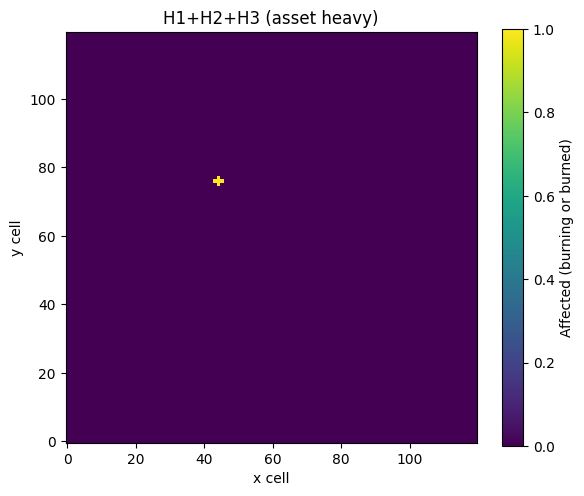

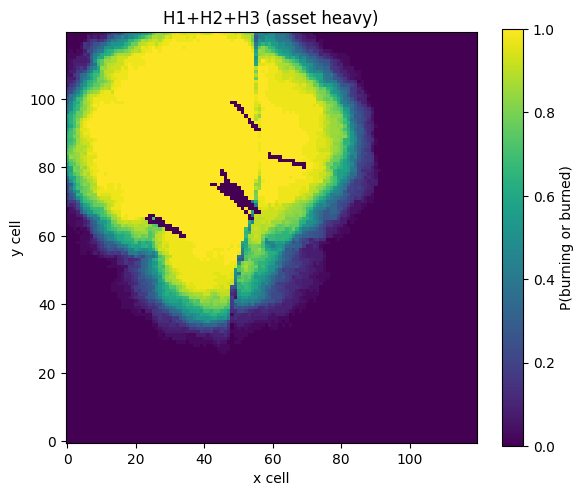

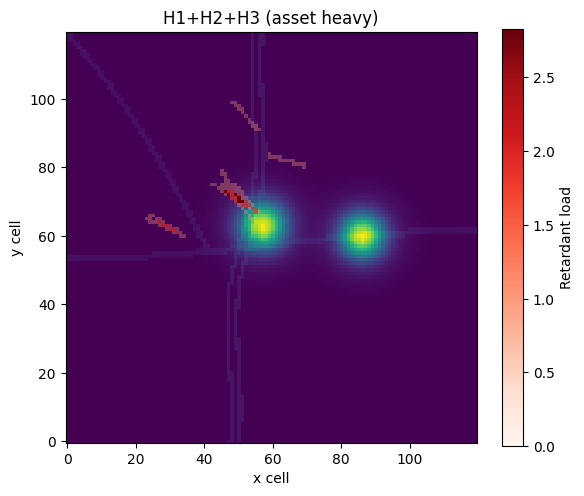

=== H1+H2+H3 (high spacing) ===
drone_params: [[26.     65.      3.9206]
 [26.     65.      4.3994]
 [41.     55.      3.2488]
 [45.     73.      1.0253]
 [47.     73.      0.921 ]
 [48.     74.      0.8604]
 [50.     70.      0.7923]
 [50.     71.      0.3867]
 [51.     72.      0.7514]
 [55.     94.      0.4859]]
Applying retardant drop: D=[[26.     65.      3.9206]
 [26.     65.      4.3994]
 [41.     55.      3.2488]
 [45.     73.      1.0253]
 [47.     73.      0.921 ]
 [48.     74.      0.8604]
 [50.     70.      0.7923]
 [50.     71.      0.3867]
 [51.     72.      0.7514]
 [55.     94.      0.4859]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=13.8921 | best=13.8921
           (x,y,phi) per drone:
           [[26.     65.      3.9206]
 [26.     65.      4.3994]
 [41.     55.      3.2488]
 [45.     73.      1.0253]
 [47.     73.      0.921 ]
 [48.     74.      0.8604]
 [50.     70.      0.7923]
 [50.     71.      0.3867]
 [51.     72.      0.7514]
 [55.

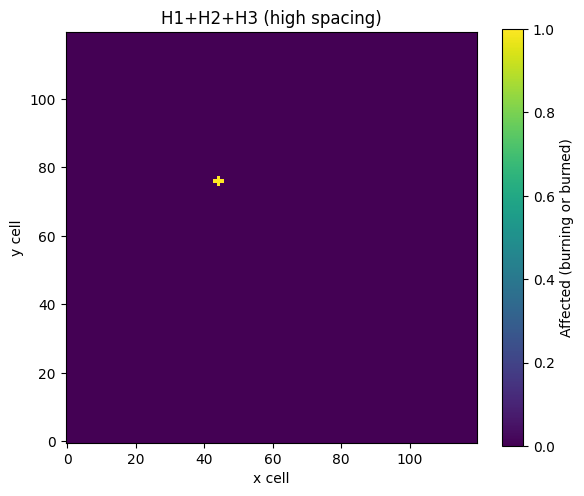

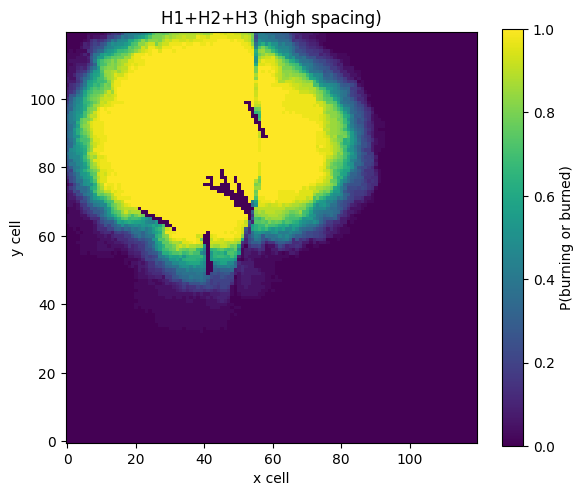

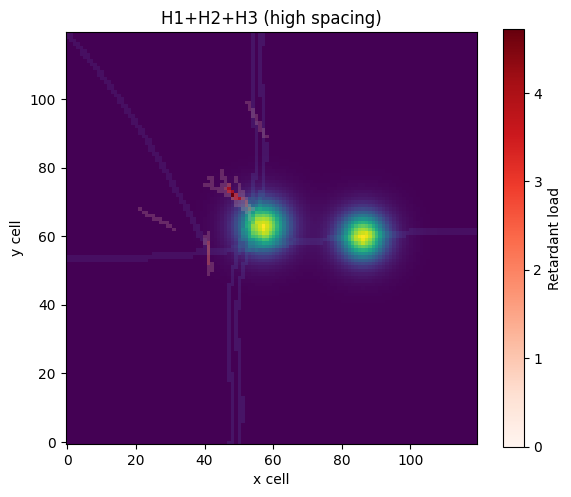

=== H1/H2/H3 w allocations ===
drone_params: [[29.     62.      4.0963]
 [29.     63.      3.8067]
 [46.     73.      0.5283]
 [46.     73.      0.5611]
 [47.     73.      0.8834]
 [47.     74.      0.5812]
 [47.     74.      0.765 ]
 [50.     70.      0.5995]
 [51.     72.      0.5314]
 [60.     88.      0.7088]]
Applying retardant drop: D=[[29.     62.      4.0963]
 [29.     63.      3.8067]
 [46.     73.      0.5283]
 [46.     73.      0.5611]
 [47.     73.      0.8834]
 [47.     74.      0.5812]
 [47.     74.      0.765 ]
 [50.     70.      0.5995]
 [51.     72.      0.5314]
 [60.     88.      0.7088]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.2498 | best=14.2498
           (x,y,phi) per drone:
           [[29.     62.      4.0963]
 [29.     63.      3.8067]
 [46.     73.      0.5283]
 [46.     73.      0.5611]
 [47.     73.      0.8834]
 [47.     74.      0.5812]
 [47.     74.      0.765 ]
 [50.     70.      0.5995]
 [51.     72.      0.5314]
 [60. 

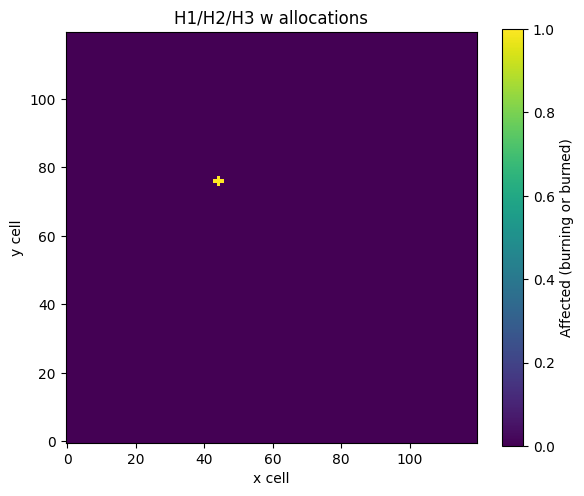

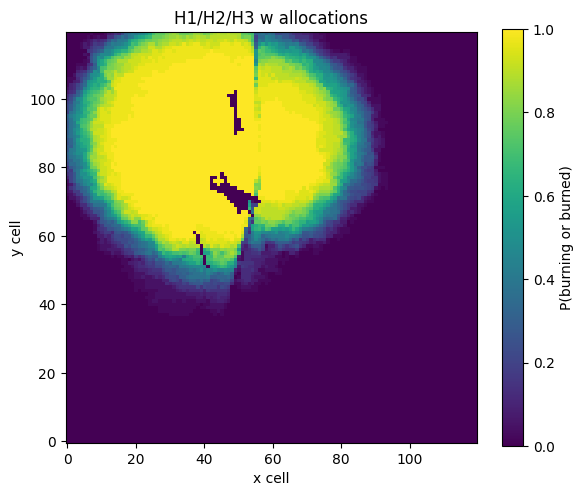

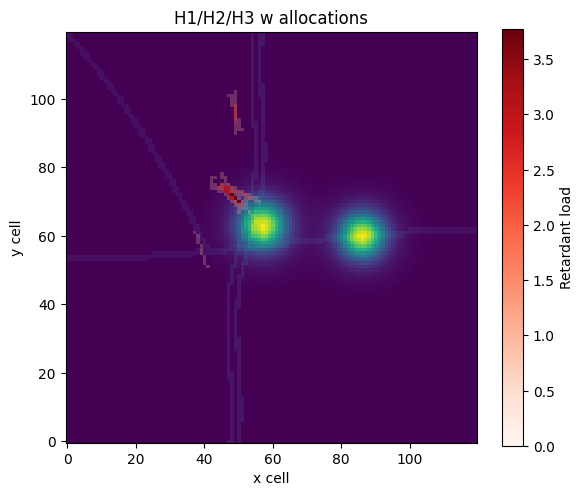

=== boundary ===
drone_params: [[36.     49.      1.8591]
 [46.     56.      2.1394]
 [47.     59.      0.7115]
 [56.     51.      0.9565]
 [57.     62.      0.6155]
 [62.     73.      0.9795]
 [63.     63.      0.7749]
 [67.     68.      0.7035]
 [67.     86.      5.9796]
 [70.     80.      5.9078]]
Applying retardant drop: D=[[36.     49.      1.8591]
 [46.     56.      2.1394]
 [47.     59.      0.7115]
 [56.     51.      0.9565]
 [57.     62.      0.6155]
 [62.     73.      0.9795]
 [63.     63.      0.7749]
 [67.     68.      0.7035]
 [67.     86.      5.9796]
 [70.     80.      5.9078]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
[Heuristic] eval 001/16 | y=14.1235 | best=14.1235
           (x,y,phi) per drone:
           [[36.     49.      1.8591]
 [46.     56.      2.1394]
 [47.     59.      0.7115]
 [56.     51.      0.9565]
 [57.     62.      0.6155]
 [62.     73.      0.9795]
 [63.     63.      0.7749]
 [67.     68.      0.7035]
 [67.     86.      5.9796]
 [70.     80.      5

In [ ]:
n_evals = 16
plot_each = True
n_sims_plot = 40
fail_on_duplicates = False

heuristic_suite = [
    # Baselines
    ("H1+H2+H3 default", {}),
    ("H1+H2+H3 (wider spacing)", {"min_arc_sep_frac": 0.35}),
    ("H1+H2+H3 (low jitter)", {"phi_jitter_rad": np.deg2rad(3.0)}),
    ("H1+H2+H3 (high spacing + low jitter)", {"min_arc_sep_frac": 0.40, "phi_jitter_rad": np.deg2rad(3.0)}),

    # H1 variants (asset blocking)
    ("H1 asset-focused (tight)", {
        "heuristic_modes": ["fire_asset_blocking"],
        "asset_value_quantile": 0.95,
        "asset_alpha_range": (0.55, 0.85),
        "min_arc_sep_frac": 0.25,
        "phi_jitter_rad": np.deg2rad(4.0),
    }),
    ("H1 asset-focused (broader)", {
        "heuristic_modes": ["fire_asset_blocking"],
        "asset_value_quantile": 0.85,
        "asset_alpha_range": (0.35, 0.75),
        "min_arc_sep_frac": 0.20,
        "phi_jitter_rad": np.deg2rad(6.0),
    }),
    ("H1 asset + boundary fallback", {
        "heuristic_modes": ["fire_asset_blocking", "boundary"],
        "asset_value_quantile": 0.90,
        "value_bias": 0.4,
        "wind_bias": 1.2,
    }),
    ("H1 asset (high spacing)", {
        "heuristic_modes": ["fire_asset_blocking"],
        "asset_value_quantile": 0.92,
        "asset_alpha_range": (0.50, 0.80),
        "min_arc_sep_frac": 0.40,
        "phi_jitter_rad": np.deg2rad(3.0),
    }),
    ("H1 asset (close-in, spaced)", {
        "heuristic_modes": ["fire_asset_blocking"],
        "asset_value_quantile": 0.90,
        "asset_alpha_range": (0.30, 0.55),
        "min_arc_sep_frac": 0.35,
        "phi_jitter_rad": np.deg2rad(4.0),
    }),

    # H2 variants (downwind)
    ("H2 downwind (perp, layered)", {
        "heuristic_modes": ["downwind_blocking"],
        "downwind_offset_cells": 8.0,
        "downwind_orientation": "perp",
        "downwind_min_arc_sep_frac": 0.25,
        "downwind_layer_spacing_cells": 4.0,
    }),
    ("H2 downwind (perp, close-in)", {
        "heuristic_modes": ["downwind_blocking"],
        "downwind_offset_cells": 5.0,
        "downwind_orientation": "perp",
        "downwind_min_arc_sep_frac": 0.20,
        "downwind_layer_spacing_cells": 3.0,
    }),
    ("H2 downwind (perp, high spacing)", {
        "heuristic_modes": ["downwind_blocking"],
        "downwind_offset_cells": 8.0,
        "downwind_orientation": "perp",
        "downwind_min_arc_sep_frac": 0.40,
        "downwind_layer_spacing_cells": 5.0,
    }),
    ("H2 downwind (perp, multi-layer)", {
        "heuristic_modes": ["downwind_blocking"],
        "downwind_offset_cells": 7.0,
        "downwind_orientation": "perp",
        "downwind_min_arc_sep_frac": 0.30,
        "downwind_layer_spacing_cells": 4.0,
        "downwind_max_layers": 3,
    }),
    ("H2 downwind (parallel, legacy)", {
        "heuristic_modes": ["downwind_blocking"],
        "downwind_offset_cells": 8.0,
        "downwind_orientation": "parallel",
        "downwind_min_arc_sep_frac": 0.25,
        "downwind_layer_spacing_cells": 4.0,
    }),

    # H3 variants (tangent/normal)
    ("H3 tangent (normal)", {
        "heuristic_modes": ["tangent_blocking"],
        "tangent_orientation": "normal",
        "tangent_offset_cells": 3.0,
        "tangent_wind_scale": 3.0,
        "tangent_shoulder_align": (0.20, 0.70),
    }),
    ("H3 tangent (normal, farther)", {
        "heuristic_modes": ["tangent_blocking"],
        "tangent_orientation": "normal",
        "tangent_offset_cells": 5.0,
        "tangent_wind_scale": 3.5,
        "tangent_shoulder_align": (0.15, 0.65),
    }),
    ("H3 tangent (normal, high spacing)", {
        "heuristic_modes": ["tangent_blocking"],
        "tangent_orientation": "normal",
        "tangent_offset_cells": 4.0,
        "tangent_wind_scale": 3.0,
        "tangent_shoulder_align": (0.10, 0.55),
    }),
    ("H3 tangent (parallel, legacy)", {
        "heuristic_modes": ["tangent_blocking"],
        "tangent_orientation": "tangent",
        "tangent_offset_cells": 3.0,
        "tangent_wind_scale": 3.0,
        "tangent_shoulder_align": (0.20, 0.70),
    }),

    # H1/H2/H3 mixes
    ("H1+H2", {
        "heuristic_modes": ["fire_asset_blocking", "downwind_blocking"],
        "asset_value_quantile": 0.90,
        "downwind_offset_cells": 8.0,
        "downwind_orientation": "perp",
        "downwind_min_arc_sep_frac": 0.25,
    }),
    ("H1+H3", {
        "heuristic_modes": ["fire_asset_blocking", "tangent_blocking"],
        "asset_value_quantile": 0.90,
        "tangent_orientation": "normal",
        "tangent_offset_cells": 4.0,
    }),
    ("H2+H3", {
        "heuristic_modes": ["downwind_blocking", "tangent_blocking"],
        "downwind_offset_cells": 8.0,
        "downwind_orientation": "perp",
        "tangent_orientation": "normal",
        "tangent_offset_cells": 3.0,
    }),
    ("H1+H2+H3 (asset heavy)", {
        "heuristic_modes": ["fire_asset_blocking", "downwind_blocking", "tangent_blocking"],
        "asset_value_quantile": 0.95,
        "downwind_offset_cells": 8.0,
        "downwind_orientation": "perp",
        "tangent_orientation": "normal",
        "min_arc_sep_frac": 0.30,
    }),
    ("H1+H2+H3 (high spacing)", {
        "heuristic_modes": ["fire_asset_blocking", "downwind_blocking", "tangent_blocking"],
        "asset_value_quantile": 0.90,
        "downwind_offset_cells": 7.0,
        "downwind_orientation": "perp",
        "downwind_min_arc_sep_frac": 0.35,
        "tangent_orientation": "normal",
        "tangent_offset_cells": 4.0,
        "min_arc_sep_frac": 0.40,
    }),
    ("H1/H2/H3 w allocations", {
        "heuristic_modes": ["fire_asset_blocking", "downwind_blocking", "tangent_blocking"],
        "heuristic_allocations": {"fire_asset_blocking": 0.5, "downwind_blocking": 0.25, "tangent_blocking": 0.25},
        "asset_value_quantile": 0.92,
        "downwind_offset_cells": 7.0,
        "downwind_orientation": "perp",
        "tangent_orientation": "normal",
        "min_arc_sep_frac": 0.35,
    }),

    # Other heuristics (legacy)
    ("boundary", {"heuristic_modes": ["boundary"], "wind_bias": 2.0}),
    ("boundary (high spacing)", {"heuristic_modes": ["boundary"], "wind_bias": 2.0, "min_arc_sep_frac": 0.40}),
    ("control_tie_in", {"heuristic_modes": ["control_tie_in"], "control_bias": 2.0}),
    ("contingency", {"heuristic_modes": ["contingency"], "contingency_alpha_range": (0.7, 0.95)}),
    ("point_protection", {"heuristic_modes": ["point_protection"], "point_value_quantile": 0.90, "point_exclusion_cells": 8.0}),
    ("head_flank", {"heuristic_modes": ["head_flank"], "head_frac": 0.5, "flank_frac": 0.3, "back_frac": 0.2}),
    ("confine", {"heuristic_modes": ["confine"], "confine_offset_cells": 4.0}),
    ("confine (wider)", {"heuristic_modes": ["confine"], "confine_offset_cells": 6.0}),
    ("effective_interaction (filter)", {
        "heuristic_modes": ["boundary", "effective_interaction"],
        "effective_min_final_prob": 0.2,
        "effective_max_boundary_dist": 6.0,
    }),

    # Broad mix
    ("full mix", {
        "heuristic_modes": ["fire_asset_blocking", "downwind_blocking", "tangent_blocking", "boundary", "control_tie_in"],
        "control_bias": 1.5,
        "value_bias": 0.4,
    }),
    ("full mix (high spacing)", {
        "heuristic_modes": ["fire_asset_blocking", "downwind_blocking", "tangent_blocking", "boundary", "control_tie_in"],
        "control_bias": 1.5,
        "value_bias": 0.4,
        "min_arc_sep_frac": 0.35,
        "downwind_min_arc_sep_frac": 0.35,
    }),
]

results = []
for name, hkwargs in heuristic_suite:
    print(f"=== {name} ===")
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=n_evals,
        heuristic_random_frac=0.0,
        heuristic_kwargs=hkwargs,
        print_every=n_evals,
    )
    stats = drop_stats(best_params)
    print(
        f"best_y={best_y:.6g} | drops={stats['n_drops']} | "
        f"unique={stats['n_unique']} | dup={stats['n_dup']} | min_dist={stats['min_dist']:.2f}"
    )

    if fail_on_duplicates and stats["n_dup"] > 0:
        raise AssertionError(f"Duplicates found in {name}: {stats}")

    results.append({
        "name": name,
        "best_y": best_y,
        "stats": stats,
        "best_theta": best_theta,
    })

    if plot_each:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=n_sims_plot, title=name)

print("Summary (lower is better):")
for row in sorted(results, key=lambda r: r["best_y"]):
    s = row["stats"]
    print(f"{row['name']}: best_y={row['best_y']:.6g} | dup={s['n_dup']} | min_dist={s['min_dist']:.2f}")


In [ ]:
# Custom heuristic generators (not in bo.py) + parameter sweeps.

ctx = drop_opt._build_heuristic_context()

inner_xy = ctx["inner_xy"]
outer_xy = ctx["outer_xy"]
v_out = ctx["v_out"]
wind_unit = ctx["wind_unit"]
value_scores = ctx["value_scores"]
control_scores = ctx["control_scores"]
tangents = ctx["tangents"]
normals = ctx["normals"]
value_map = ctx["value_map"]

K = inner_xy.shape[0]


def _compact_scores(scores, compactness):
    compactness = float(np.clip(compactness, 0.0, 1.0))
    if compactness >= 1.0:
        return scores
    best = int(np.nanargmax(scores))
    span = int(max(1, np.floor(compactness * K)))
    idx = np.arange(K, dtype=int)
    dist = np.minimum((idx - best) % K, (best - idx) % K)
    keep = dist <= span
    out = np.full_like(scores, -np.inf, dtype=float)
    out[keep] = scores[keep]
    return out


def _select_indices(scores, count, min_arc_sep_frac, compactness):
    scores = _compact_scores(np.asarray(scores, float), compactness)
    min_arc = drop_opt._min_arc_for_count(K, count, float(min_arc_sep_frac))
    return drop_opt._select_spaced_by_score(count, scores, min_arc=min_arc)


def _placements_from_indices(indices, alpha, orient="tangent"):
    alpha = float(alpha)
    pts = inner_xy + alpha * v_out
    if orient == "tangent":
        phi = np.arctan2(tangents[:, 1], tangents[:, 0])
    elif orient == "normal":
        phi = np.arctan2(normals[:, 1], normals[:, 0])
    elif orient == "wind_parallel":
        phi = np.arctan2(wind_unit[1], wind_unit[0]) * np.ones(K)
    elif orient == "wind_perp":
        phi = (np.arctan2(wind_unit[1], wind_unit[0]) + np.pi / 2.0) * np.ones(K)
    else:
        raise ValueError(f"Unknown orient={orient}")
    placements = []
    for idx in indices:
        p = pts[int(idx)]
        placements.append([p[0], p[1], float(phi[int(idx)])])
    return placements


def heuristic_value_ridge(count, *, alpha, min_arc_sep_frac, compactness, value_power=1.0, control_weight=0.0, orient="tangent"):
    scores = np.power(np.clip(value_scores, 0.0, None), float(value_power))
    if float(control_weight) != 0.0:
        scores = scores * np.exp(float(control_weight) * control_scores)
    idx = _select_indices(scores, count, min_arc_sep_frac, compactness)
    return _placements_from_indices(idx, alpha, orient=orient)


def heuristic_crosswind_barrier(count, *, alpha, min_arc_sep_frac, compactness, crosswind_power=1.0, value_weight=0.0, orient="tangent"):
    align = np.clip(np.sum(ctx["v_unit"] * wind_unit, axis=1), -1.0, 1.0)
    cross = 1.0 - np.abs(align)
    scores = np.power(np.clip(cross, 0.0, None), float(crosswind_power))
    if float(value_weight) != 0.0:
        scores = scores * np.exp(float(value_weight) * value_scores)
    idx = _select_indices(scores, count, min_arc_sep_frac, compactness)
    return _placements_from_indices(idx, alpha, orient=orient)


def heuristic_centroid_guard(count, *, alpha, min_arc_sep_frac, compactness, value_quantile=0.9, orient="tangent"):
    flat = value_map.ravel()
    thresh = np.quantile(flat, float(np.clip(value_quantile, 0.0, 1.0)))
    mask = value_map >= thresh
    if not np.any(mask):
        return _placements_from_indices([], alpha, orient=orient)
    coords = np.column_stack(np.where(mask)).astype(float)
    centroid = coords.mean(axis=0)
    vec = centroid[None, :] - inner_xy
    vnorm = np.linalg.norm(vec, axis=1) + 1e-9
    unit = vec / vnorm[:, None]
    scores = np.sum(unit * ctx["v_unit"], axis=1)
    idx = _select_indices(scores, count, min_arc_sep_frac, compactness)
    return _placements_from_indices(idx, alpha, orient=orient)


def evaluate_placements(name, placements):
    params = np.asarray(placements, float)
    if params.size == 0:
        return {"name": name, "objective": np.nan, "n": 0}
    theta = drop_opt._encode_params(params)
    y = float(drop_opt.expected_value_burned_area(theta))
    return {"name": name, "objective": y, "n": params.shape[0], "theta": theta, "params": params}

In [ ]:
# Parameter sweeps for custom heuristics.

sweep_results = []

count = drop_opt.n_drones

value_grid = {
    "alpha": [0.35, 0.50, 0.65],
    "min_arc_sep_frac": [0.2, 0.3],
    "compactness": [0.2, 0.5, 0.8],
    "value_power": [1.0, 1.5],
}

for alpha in value_grid["alpha"]:
    for sep in value_grid["min_arc_sep_frac"]:
        for comp in value_grid["compactness"]:
            for vp in value_grid["value_power"]:
                placements = heuristic_value_ridge(
                    count,
                    alpha=alpha,
                    min_arc_sep_frac=sep,
                    compactness=comp,
                    value_power=vp,
                    control_weight=0.3,
                    orient="tangent",
                )
                name = f"value_ridge a={alpha} sep={sep} comp={comp} vp={vp}"
                sweep_results.append(evaluate_placements(name, placements))

cross_grid = {
    "alpha": [0.45, 0.60],
    "min_arc_sep_frac": [0.2, 0.3],
    "compactness": [0.3, 0.6],
    "crosswind_power": [1.0, 2.0],
}

for alpha in cross_grid["alpha"]:
    for sep in cross_grid["min_arc_sep_frac"]:
        for comp in cross_grid["compactness"]:
            for cp in cross_grid["crosswind_power"]:
                placements = heuristic_crosswind_barrier(
                    count,
                    alpha=alpha,
                    min_arc_sep_frac=sep,
                    compactness=comp,
                    crosswind_power=cp,
                    value_weight=0.2,
                    orient="tangent",
                )
                name = f"crosswind a={alpha} sep={sep} comp={comp} cp={cp}"
                sweep_results.append(evaluate_placements(name, placements))

centroid_grid = {
    "alpha": [0.35, 0.55],
    "min_arc_sep_frac": [0.2, 0.3],
    "compactness": [0.3, 0.6],
    "value_quantile": [0.85, 0.92],
}

for alpha in centroid_grid["alpha"]:
    for sep in centroid_grid["min_arc_sep_frac"]:
        for comp in centroid_grid["compactness"]:
            for vq in centroid_grid["value_quantile"]:
                placements = heuristic_centroid_guard(
                    count,
                    alpha=alpha,
                    min_arc_sep_frac=sep,
                    compactness=comp,
                    value_quantile=vq,
                    orient="tangent",
                )
                name = f"centroid a={alpha} sep={sep} comp={comp} vq={vq}"
                sweep_results.append(evaluate_placements(name, placements))

# Show top results (lower objective is better if using expected burned value).

sweep_results = [r for r in sweep_results if np.isfinite(r.get("objective", np.nan))]

best = sorted(sweep_results, key=lambda r: r["objective"])[:10]
print("Top 10 heuristic sweep results:")
for r in best:
    print(f"{r['name']}: y={r['objective']:.4f} n={r['n']}")

In [ ]:
# Visualize best custom heuristic from the sweep.

if best:
    best_item = best[0]
    params = best_item["params"]
    print("Best custom heuristic:", best_item["name"], "objective=", best_item["objective"])

    state = FireState(
        burning=np.zeros((1, realistic_env.grid_size[0], realistic_env.grid_size[1]), dtype=bool),
        burned=np.zeros((1, realistic_env.grid_size[0], realistic_env.grid_size[1]), dtype=bool),
        burn_remaining_s=np.zeros((1, realistic_env.grid_size[0], realistic_env.grid_size[1]), dtype=float),
        retardant=np.zeros((1, realistic_env.grid_size[0], realistic_env.grid_size[1]), dtype=float),
        t=0,
    )

    fire_model.apply_retardant_cartesian(
        state,
        params,
        drop_w_km=realistic_env.drop_w_km,
        drop_h_km=realistic_env.drop_h_km,
        amount=1.0,
        avoid_burning=False,
        forbid_burning_overlap=False,
        burning_prob_threshold=0.25,
        cell_cap=None,
    )

    plt.figure(figsize=(6, 5))
    plt.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds")
    plt.title("Best custom heuristic placement")
    plt.tight_layout()
    plt.show()